In [56]:
att_cnn_bilstm_cross_validate_model_path = "saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5"
cnn_bilstm_cross_validate_model_path = "saved_model/best_CNN_BiLSTM_Cross_validation.hdf5"
cnn_cross_validate_model_path = "saved_model/best_CNN_Cross_validation.hdf5"
bisltm_cross_validate_model_path = "saved_model/best_BiLSTM_Cross_validation.hdf5"

# defining the hyperparameters
learning_rate = 1e-3
learning_decay = 1e-10 # 1e-4
batch_size= 64 # 128
epochs = 10

spa_dropout_ratio = 0.2 # dropout ration, dropping a entire feature map
kernel_size = 3 # [1,2,3,5] # [1,2,3,5] Size of the kernel. Mixing kernels of various sizes.
                # specifying the length of the 1D convolution window.
dense_units = 64 # hidden unit 128 the number of neurons in the hidden layer
dropout_ratio = 0.1 # 0.1 Dropout Ratio
num_filters = 50 # 36, 128, 256 number of kernels, conv_size
                # Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

lstm_units_1 = 64 # the size(dim) of the hidden state vector as well as the output vector.
lstm_units_2 = 32 # the size(dim) of the hidden state vector as well as the output vector.
embed_dim = 300 

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputSpec, Layer, Input, Embedding, Conv1D, Conv2D, Bidirectional, Dense, Attention
from tensorflow.keras.layers import LSTM, Activation, Add, Flatten, Concatenate, concatenate # CuDNNGRU, CuDNNLSTM, 
from tensorflow.keras.layers import Reshape, Dropout, SpatialDropout1D, BatchNormalization
from tensorflow.keras.layers import MaxPooling1D, MaxPool2D, GlobalAveragePooling1D, GlobalMaxPooling1D, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K 
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping, CSVLogger
from tensorflow.keras.optimizers import Adam

import string
# from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer, WordNetLemmatizer

from glob import glob
from tqdm import tqdm

from time import time
from timeit import default_timer as timer
from datetime import datetime

import re, copy
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report



In [57]:
import pandas as pd
import numpy as np
train_set = pd.read_csv("/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/v11/vistec/vistec_1/vistec_80_percent_1.csv", header= None,names=["text", "label"])
test_unseen = pd.read_csv("/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/v11/vistec/vistec_1/vistec_20_percent_1.csv",  header= None,names=["text", "label"])

# all_dataset =  pd.read_csv("/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/v11/original/original_1/original_dataset.csv",  header= None,names=["text", "label"])

In [153]:
train_set

,text,label
0,หลักฐานการถ่ายโอนฤดูร้อน,ชำระเงิน/ใบเสร็จรับเงิน
1,ไง ฉันอยากจะถามว่าเทอมที่แล้วของฉันคือเทอมที่ ...,เกรด
2,ได้โปรดอีกครั้งนะ ฉันเพิ่งมีพนักงานโทรหาฉัน เบ...,แจ้งจบ/ขึ้นทะเบียนบัณฑิต
3,สวัสดี ฉันต้องการขอคุณสมบัติและสัตวแพทย์ แต่เว...,ขอเอกสาร/ใบรับรอง
4,ฉันยังไม่ได้ส่งใบรับรองจากโรงเรียนเก่า,ขอเอกสาร/ใบรับรอง
...,...,...
5769,ขอบคุณค่ะ ขอยืนยันอีกครั้งได้มั้ยคะ,ลงทะเบียนเรียน
5770,ทําตัวเองชอบเมื่อฉันจ่ายให้ในสํานักงานคุณต้องก...,ชำระเงิน/ใบเสร็จรับเงิน
5771,ฉันจะจ่ายด้วยใบอนุญาตระดับบัณฑิตศึกษา แต่มันขึ...,ชำระเงิน/ใบเสร็จรับเงิน
5772,ฉันแค่อยากรู้ว่ามันเป็นรหัสนักเรียนใหม่ของ 64 ...,สถานภาพนักศึกษา


In [154]:
test_unseen

,text,label,clean_text,encoded_original_label
0,โควต้าคืออะไรเหรอ,ลงทะเบียนเรียน,โควต้า เหรอ,3
1,เอกสารระดับบัณฑิตศึกษาคือเมื่อไหร่,ขอเอกสาร/ใบรับรอง,เอกสาร ระดับ บัณฑิตศึกษา,0
2,ฮัลโหล ฉันถามเรื่องการจ่ายเงินเมื่อปีที่แล้วแต...,ขอเอกสาร/ใบรับรอง,ฮัลโหล ถาม เรื่อง จ่าย เงิน ปี หยิบ ( หยุด...,0
3,การถอนตัวนั้นไม่ได้เรียกเก็บเงินจากหน่วยของขวั...,ลงทะเบียนเรียน,ถอนตัว เรียกเก็บเงิน หน่วย ของขวัญ ?,3
4,จะมีการลงทะเบียนตรงเวลาหรือไม่?,แจ้งจบ/ขึ้นทะเบียนบัณฑิต,ลงทะเบียน ตรงเวลา ?,6
...,...,...,...,...
1439,ตรวจสอบผลลัพธ์ของเอกสารไปรษณีย์,ขอเอกสาร/ใบรับรอง,ตรวจสอบ ผลลัพธ์ เอกสาร ไปรษณีย์,0
1440,ถ้าฉันอยู่ในตําแหน่งดวงจันทร์ ฉันเข้าเรียนฟรีข...,ลงทะเบียนเรียน,ตํา แห น่ง ดวงจันทร์ เข้าเรียน ฟรี รังสิต ไห...,3
1441,สวัสดี ฉันอยากจะถามเธอเรื่องการติดต่อพีเอชดีกา...,ขอเอกสาร/ใบรับรอง,สวัสดี ถาม เรื่อง ติดต่อ พี เอช ดี การ์ด สํา...,0
1442,ไม่ได้เก็บอะไรไว้,ชำระเงิน/ใบเสร็จรับเงิน,,1


In [58]:
from sklearn.model_selection import train_test_split
message_train, message_test, label_train, label_test = train_test_split(train_set["text"], train_set["label"], test_size=0.15,stratify=train_set["label"])

test = pd.DataFrame()
test["text"]=message_test
test["label"]=label_test


In [59]:
message_train_2, message_validation, label_train_2, label_validation = train_test_split(message_train, label_train, test_size=0.1765,stratify=label_train)
train = pd.DataFrame()
train["text"]=message_train_2
train["label"]=label_train_2

validate = pd.DataFrame()
validate["text"]=message_validation
validate["label"]=label_validation

In [60]:
validate["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           266
ลงทะเบียนเรียน              228
ชำระเงิน/ใบเสร็จรับเงิน     171
แจ้งจบ/ขึ้นทะเบียนบัณฑิต    107
ประวัตินักศึกษา              35
สถานภาพนักศึกษา              31
เกรด                         29
Name: count, dtype: int64

In [61]:
train["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           1239
ลงทะเบียนเรียน              1065
ชำระเงิน/ใบเสร็จรับเงิน      799
แจ้งจบ/ขึ้นทะเบียนบัณฑิต     496
ประวัตินักศึกษา              164
สถานภาพนักศึกษา              144
เกรด                         133
Name: count, dtype: int64

In [62]:
test_unseen["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           443
ลงทะเบียนเรียน              380
ชำระเงิน/ใบเสร็จรับเงิน     285
แจ้งจบ/ขึ้นทะเบียนบัณฑิต    178
ประวัตินักศึกษา              58
สถานภาพนักศึกษา              52
เกรด                         48
Name: count, dtype: int64

In [63]:
test["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           266
ลงทะเบียนเรียน              229
ชำระเงิน/ใบเสร็จรับเงิน     171
แจ้งจบ/ขึ้นทะเบียนบัณฑิต    107
ประวัตินักศึกษา              35
สถานภาพนักศึกษา              31
เกรด                         28
Name: count, dtype: int64

In [64]:
# all_dataset["label"].value_counts()

In [65]:
!pip install sklearn_crfsuite
!pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
# !pip install fastai=÷=1.0.46

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
# nltk.download('punkt')
# nltk.download('stopwords')
from pythainlp.corpus import thai_stopwords
stopwords = thai_stopwords()

zsh:1: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/bin/pip: bad interpreter: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification-using-novel-CNN-Bi-LSTM-framework/venv/bin/python3.11: no such file or directory


You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
zsh:1: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/bin/pip: bad interpreter: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification-using-novel-CNN-Bi-LSTM-framework/venv/bin/python3.11: no such file or directory
  Using cached https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
  Installing build dependencies ... done
pythainlp requires Python '>=3.7' but the running Python is 2.7.16
You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [66]:

# from pythainlp.corpus import thai_stopwords
from pythainlp import word_tokenize

def lower_text(text):
    return text.lower()

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'', text)

def remove_punct(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        text = text.replace(p, f' {p} ')
    return text

def remove_stopwords(text):
    text = ' '.join([word for word in word_tokenize(text,engine='newmm') if word not in (stopwords)])
    return text

In [67]:
def clean_text(text):
    # print(text)
    # text = lower_text(text)
    text_str = str(text)
    text = remove_number(text_str)
    text = remove_punct(text_str)
    text = remove_stopwords(text_str)

    return text

In [68]:
# all_dataset["clean_text"] = all_dataset["text"].apply(clean_text)
test_unseen["clean_text"] = test_unseen["text"].apply(clean_text)
train["clean_text"] = train["text"].apply(clean_text)
test["clean_text"] = test["text"].apply(clean_text)
validate["clean_text"] =  validate["text"].apply(clean_text)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# all_dataset["encoded_original_label"] = label_encoder.fit_transform(all_dataset["label"])
test_unseen["encoded_original_label"] = label_encoder.fit_transform(test_unseen["label"])
test["encoded_original_label"] = label_encoder.fit_transform(test["label"])
train["encoded_original_label"] = label_encoder.fit_transform(train["label"])
validate["encoded_original_label"] = label_encoder.fit_transform(validate["label"])

In [69]:
from keras.utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras import layers
from keras.models import Sequential


act= "relu"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

In [70]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [71]:
!pip3 install textblob  

zsh:1: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/bin/pip3: bad interpreter: /Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification-using-novel-CNN-Bi-LSTM-framework/venv/bin/python3.11: no such file or directory

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


## Feed-Forward Networks with Attention Can Solve Some Long-Term Memory Problems
###### https://arxiv.org/abs/1512.08756

In [72]:
class Attention(Layer):
    """
    Keras Layer that implements an Attention mechanism for temporal data.
    Supports Masking.
    Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    :param kwargs:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(Attention())
    """
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None
        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))
        if self.bias:
            eij += self.b
        eij = K.tanh(eij)
        a = K.exp(eij)
        if mask is not None:
            a *= K.cast(mask, K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

## Hierarchical Attention Networks for Document Classification
##### http://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf

In [73]:
# https://towardsdatascience.com/nlp-learning-series-part-3-attention-cnn-and-what-not-for-text-classification-4313930ed566
# https://www.kaggle.com/code/duykhanh99/bidirectional-lstm-cnn-attention-model/notebook
    
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    
    
def create_custom_objects():
    instance_holder = {"instance": None}

    class ClassWrapper(AttentionWithContext):
        def __init__(self, *args, **kwargs):
            instance_holder["instance"] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)

    def loss(*args):
        method = getattr(instance_holder["instance"], "loss_function")
        return method(*args)

    def accuracy(*args):
        method = getattr(instance_holder["instance"], "accuracy")
        return method(*args)
    return {"ClassWrapper": ClassWrapper ,"AttentionWithContext": ClassWrapper, "loss": loss,
            "accuracy":accuracy}


class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
        
#     def get_config(self):
#         config = super().get_config()
#         config.update({
#             "arg1": self.arg1,
#             "arg2": self.arg2,
#         })
#         return config     
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
                'W_regularizer': self.W_regularizer,
                'u_regularizer': self.u_regularizer,
                'b_regularizer': self.b_regularizer,
                'W_constraint': self.W_constraint,
                'u_constraint': self.u_constraint,
                'b_constraint': self.b_constraint,
                'bias': self.bias,
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

# Training the models

In [74]:
# Setting up our results dataframe
df_results = pd.DataFrame(columns=['F1_score', 'Precision', 'Recall', 'Accuracy', 'Training time'])
df_results_cross_val = pd.DataFrame(columns=['F1_score', 'Precision', 'Recall', 'Accuracy', 'Training time'])

In [75]:
test["encoded_original_label"]

1155    1
725     0
830     1
237     1
77      5
       ..
3623    2
2734    1
1025    2
4290    0
1262    1
Name: encoded_original_label, Length: 867, dtype: int64

In [76]:
X_train, X_test_unseen, X_test, X_validate = train["clean_text"], test_unseen["clean_text"], test["clean_text"], validate["clean_text"]


y_train, y_test_unseen, y_test, y_validate = train["encoded_original_label"], test_unseen["encoded_original_label"],test["encoded_original_label"],validate["encoded_original_label"]


temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate = X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate

# temp_message, temp_label = all_dataset["clean_text"], all_dataset["encoded_original_label"]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)

{'จ่าย': 1, 'ลงทะเบียน': 2, 'สํา': 3, 'ไหม': 4, 'หรับ': 5, 'เอกสาร': 6, 'ถาม': 7, 'ต้องการ': 8, 'นักเรียน': 9, 'สวัสดี': 10, 'เงิน': 11, 'พี่': 12, 'ภาคการศึกษา': 13, 'อ่ะ': 14, 'ออนไลน์': 15, 'ใบรับรอง': 16, 'วันที่': 17, 'เทอม': 18, 'วิชา': 19, 'การศึกษา': 20, 'ระ': 21, 'กี่': 22, 'ชํา': 23, 'ระดับ': 24, 'เรียน': 25, '2': 26, 'นะคะ': 27, 'ถอน': 28, 'รู้': 29, '1': 30, 'เรื่อง': 31, 'ดังนั้น': 32, 'ปี': 33, 'คํา': 34, 'ติดต่อ': 35, 'มหาวิทยาลัย': 36, 'ตอนนี้': 37, 'ที่จะ': 38, 'บัณฑิตศึกษา': 39, 'ดี': 40, 'เกรด': 41, 'ระบบ': 42, 'รอ': 43, 'โควต้า': 44, '3': 45, 'ํา': 46, 'สถานะ': 47, 'อยากรู้': 48, 'ใบเสร็จ': 49, 'ข้อมูล': 50, 'ชื่อ': 51, 'ตรวจสอบ': 52, 'ฤดูร้อน': 53, 'นายทะเบียน': 54, 'เวลา': 55, 'บอ': 56, 'จบ': 57, 'ค่าธรรมเนียม': 58, 'เว็บไซต์': 59, 'กํา': 60, 'รหัส': 61, 'จํา': 62, 'ลัง': 63, 'แจ้ง': 64, 'เดือน': 65, 'ใด': 66, 'เหรอ': 67, 'ฮัลโหล': 68, 'ชั้นเรียน': 69, 'บัตร': 70, 'ใบอนุญาต': 71, 'คําขอ': 72, 'ขอบคุณ': 73, 'บัณฑิต': 74, 'ตอน': 75, 'ทราบ': 76, '64': 77, 'โมง': 78, 

In [77]:
train["label"].value_counts()

label
ขอเอกสาร/ใบรับรอง           1239
ลงทะเบียนเรียน              1065
ชำระเงิน/ใบเสร็จรับเงิน      799
แจ้งจบ/ขึ้นทะเบียนบัณฑิต     496
ประวัตินักศึกษา              164
สถานภาพนักศึกษา              144
เกรด                         133
Name: count, dtype: int64

## Att CNN-BiLSTM MODEL

In [78]:
def build_model_1(lr=0.0, lr_d=0.0, spatial_dr=0.0, kernel_size=3,
                  dense_units=128, dropout_ratio=0.0, num_filters=32,
                  lstm_units_1=0, lstm_units_2=0, batch_size=64, epochs=10):
    
    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(
        MAX_NB_WORDS, 
        embed_dim, 
        input_length=max_length,
        name = "embedding"
        )(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spatial_dr)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2, return_sequences=True))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
#     x = Dense(64, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
    x = AttentionWithContext()(x)
    x = Dense(dense_units, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(7, activation="softmax")(x)
    model = Model(model_input, model_output)
    
    ######################## COMPILING THE MODEL ##################################
    model.compile(
        loss = "categorical_crossentropy", 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=lr_d),
#         optimizer='adam',
        metrics = [
            "accuracy",
#             "binary_accuracy",
#              'categorical_accuracy' ,
#             tf.keras.metrics.AUC(),
#             tf.keras.metrics.Precision(),
#             tf.keras.metrics.Recall()
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
    model_path = "saved_model/best_Attention_CNN_BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".hdf5"
    check_point = ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1,)
    
    # Display a summary of the models structure
    print(model.summary())
    print("#"*80)
    tf.keras.utils.plot_model(model, to_file="Att_cnn_BiLSTM_architecture_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".png", show_shapes=True)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history_1 = model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_validate, y_validate),
        callbacks=[check_point,early_stop])
    train_time = time() - start_time
    print(train_time)

#     model = load_model(model_path)
    model = load_model(model_path, custom_objects=create_custom_objects())
    
    ######################## EVALUATING THE MODEL ##################################  
    model.evaluate(X_test_unseen, y_test_unseen) # or model.predict
    
    return model, history_1, train_time

In [79]:
# Train proposed model
model_1, history_1, train_time = build_model_1(lr=learning_rate, lr_d=learning_decay, spatial_dr=spa_dropout_ratio, kernel_size=kernel_size,
                                            dense_units=dense_units, dropout_ratio=dropout_ratio, num_filters=num_filters, lstm_units_1=lstm_units_1,
                                            lstm_units_2=lstm_units_2, batch_size=batch_size, epochs=epochs
                                           )

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 45)]              0         
                                                                 
 embedding (Embedding)       (None, 45, 300)           852300    
                                                                 
 spatial_dropout1d_22 (Spat  (None, 45, 300)           0         
 ialDropout1D)                                                   
                                                                 
 conv1d_22 (Conv1D)          (None, 43, 50)            45050     
                                                                 
 max_pooling1d_22 (MaxPooli  (None, 21, 50)            0         
 ng1D)                                                           
                                                                 
 dropout_44 (Dropout)        (None, 21, 50)            0  

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


62/64 [============================>.] - ETA: 0s - loss: 1.7149 - accuracy: 0.2911
Epoch 1: val_loss improved from inf to 1.62489, saving model to saved_model/best_Attention_CNN_BiLSTM_20240210_13-39-47.hdf5
64/64 [==============================] - 6s 52ms/step - loss: 1.7144 - accuracy: 0.2923 - val_loss: 1.6249 - val_accuracy: 0.3391
Epoch 2/10
 3/64 [>.............................] - ETA: 2s - loss: 1.6363 - accuracy: 0.3229

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/64 [============================>.] - ETA: 0s - loss: 1.3034 - accuracy: 0.5317
Epoch 2: val_loss improved from 1.62489 to 1.13165, saving model to saved_model/best_Attention_CNN_BiLSTM_20240210_13-39-47.hdf5
64/64 [==============================] - 3s 45ms/step - loss: 1.3030 - accuracy: 0.5319 - val_loss: 1.1317 - val_accuracy: 0.6240
Epoch 3/10
62/64 [============================>.] - ETA: 0s - loss: 0.8678 - accuracy: 0.7230
Epoch 3: val_loss improved from 1.13165 to 1.03395, saving model to saved_model/best_Attention_CNN_BiLSTM_20240210_13-39-47.hdf5
64/64 [==============================] - 3s 43ms/step - loss: 0.8655 - accuracy: 0.7233 - val_loss: 1.0340 - val_accuracy: 0.6782
Epoch 4/10
62/64 [============================>.] - ETA: 0s - loss: 0.6686 - accuracy: 0.7891
Epoch 4: val_loss improved from 1.03395 to 0.96208, saving model to saved_model/best_Attention_CNN_BiLSTM_20240210_13-39-47.hdf5
64/64 [==============================] - 3s 44ms/step - loss: 0.6649 - accuracy: 0

In [80]:

# Test 15%
predicted = model_1.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)


28/28 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0     0.8405    0.7331    0.7831       266
           1     0.8773    0.8363    0.8563       171
           2     0.5714    0.6857    0.6234        35
           3     0.7584    0.8908    0.8193       229
           4     0.5000    0.1935    0.2791        31
           5     0.3030    0.3571    0.3279        28
           6     0.5000    0.5421    0.5202       107

    accuracy                         0.7382       867
   macro avg     0.6215    0.6055    0.6013       867
weighted avg     0.7437    0.7382    0.7355       867

Testing Accuracy: 0.738178
Testing Precision: 0.743652
Testing Recall: 0.738178
Testing F1 score: 0.735481


In [81]:

df_results.loc['Att-Based CNN-BiLSTM Test 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.735481,0.743652,0.738178,0.738178,24.835193


Validate 15%

In [82]:
predicted_val = model_1.predict(X_validate)

predicted_val = np.argmax(predicted_val, axis=1)
y_validate = np.argmax(y_validate,axis=1)

report = classification_report(y_validate, predicted_val, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_validate, predicted_val)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_validate, predicted_val,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_validate, predicted_val,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_validate, predicted_val,average='weighted')
print('Testing F1 score: %f' % f1)

28/28 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0     0.8705    0.7331    0.7959       266
           1     0.8035    0.8129    0.8081       171
           2     0.5122    0.6000    0.5526        35
           3     0.7321    0.8509    0.7870       228
           4     0.8000    0.1290    0.2222        31
           5     0.1143    0.1379    0.1250        29
           6     0.5081    0.5888    0.5455       107

    accuracy                         0.7151       867
   macro avg     0.6201    0.5504    0.5481       867
weighted avg     0.7339    0.7151    0.7123       867

Testing Accuracy: 0.715110
Testing Precision: 0.733879
Testing Recall: 0.715110
Testing F1 score: 0.712302


In [83]:
df_results.loc['Att-Based CNN-BiLSTM Validate 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.735481,0.743652,0.738178,0.738178,24.835193
Att-Based CNN-BiLSTM Validate 15%,0.712302,0.733879,0.715110,0.715110,24.835193


In [84]:
print(X_test_unseen)

[[ 44  67   0 ...   0   0   0]
 [  6  24  39 ...   0   0   0]
 [ 68   7  31 ...   0   0   0]
 ...
 [ 10   7  31 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [215   2   0 ...   0   0   0]]


In [85]:
# Test unseen 15%

predicted_test_unseen = model_1.predict(X_test_unseen)
print(predicted_test_unseen)
predicted_test_unseen = np.argmax(predicted_test_unseen, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted_test_unseen, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted_test_unseen)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted_test_unseen,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted_test_unseen,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted_test_unseen,average='weighted')
print('Testing F1 score: %f' % f1)

46/46 [==============================] - 0s 6ms/step
[[7.8624804e-03 8.9217415e-03 5.8907532e-04 ... 2.0577002e-03
  1.1421669e-02 9.3027474e-03]
 [2.1158551e-01 1.0613388e-02 3.3863407e-02 ... 5.9418626e-02
  2.8778253e-02 6.2971574e-01]
 [5.9292361e-02 9.1442066e-01 5.1620887e-03 ... 1.0127478e-03
  4.5360118e-04 4.8598405e-03]
 ...
 [8.3766890e-01 6.0799602e-02 3.8752239e-03 ... 2.8403651e-03
  2.5314412e-03 3.4431860e-02]
 [1.2074190e-01 7.3657274e-02 2.1530678e-02 ... 6.0038444e-02
  1.1946980e-01 2.8706583e-01]
 [1.3982704e-02 1.0712704e-02 1.2665909e-03 ... 6.0620676e-03
  4.1769482e-02 3.2348871e-02]]
              precision    recall  f1-score   support

           0     0.8482    0.7314    0.7855       443
           1     0.8224    0.7474    0.7831       285
           2     0.4848    0.5517    0.5161        58
           3     0.7365    0.8605    0.7937       380
           4     0.6154    0.1538    0.2462        52
           5     0.2407    0.2708    0.2549        48
    

In [86]:
df_results.loc['Att-Based CNN-BiLSTM Test unseen 20%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.735481,0.743652,0.738178,0.738178,24.835193
Att-Based CNN-BiLSTM Validate 15%,0.712302,0.733879,0.715110,0.715110,24.835193
Att-Based CNN-BiLSTM Test unseen 20%,0.708974,0.725424,0.710526,0.710526,24.835193


In [87]:
print(X_train)
print()
print(y_train)

[[  97  134    0 ...    0    0    0]
 [1584   78  522 ...    0    0    0]
 [ 170    7    3 ...    0    0    0]
 ...
 [ 215   23   21 ...    0    0    0]
 [ 205   34  208 ...    0    0    0]
 [ 420 1138  658 ...    0    0    0]]

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [88]:
# Define model parameters
# MAX_NB_WORDS = 1000
# embed_dim = 100
# max_length = 100
# spa_dropout_ratio = 0.2
# lstm_units_1 = 64
# lstm_units_2 = 64
# dense_units = 32
# dropout_ratio = 0.5
# learning_rate = 0.001
# learning_decay = 1e-6

# Number of folds
num_folds = 10

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_scores_att_cnn_bilstm = []
precision_scores_att_cnn_bilstm = []
f1_scores_att_cnn_bilstm = []
recall_scores_att_cnn_bilstm = []

X, y_encoded = X_train, y_train
total_train_time = 0  # Initialize total training time
# Perform cross-validation]
fold_var = 0
for i, (train_index, test_index) in enumerate(kf.split(X, y_encoded.argmax(1))):
    fold_var +=1
    print("------ Fold ----------", fold_var)
   
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]
    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(
        MAX_NB_WORDS, 
        embed_dim, 
        input_length=max_length,
        name = "embedding"
        )(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spa_dropout_ratio)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2, return_sequences=True))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
#     x = Dense(64, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
    x = AttentionWithContext()(x)
    x = Dense(dense_units, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(7, activation="softmax")(x)
    att_cnn_bilstm_model = Model(model_input, model_output)

    ######################## COMPILING THE MODEL ##################################
    att_cnn_bilstm_model.compile(
        loss = "categorical_crossentropy", 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
#         optimizer='adam',
        metrics = [
            "accuracy",
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
    check_point = ModelCheckpoint(att_cnn_bilstm_cross_validate_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1)
    callbacks_list = [check_point,early_stop]
    
    # Display a summary of the models structure
    print(att_cnn_bilstm_model.summary())
    print("#"*80)
   
    # Train the model
    start_time = time()
    att_cnn_bilstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks_list, verbose=1)
    total_train_time += train_time 
    
    y_pred=np.argmax(att_cnn_bilstm_model.predict(X_val), axis=-1)
    y_true_validation_test = np.argmax(y_val,axis = 1)
    
    accuracy_scores_att_cnn_bilstm.append(accuracy_score(y_true_validation_test, y_pred))
    precision_scores_att_cnn_bilstm.append(precision_score(y_true_validation_test, y_pred, average='weighted'))
    f1_scores_att_cnn_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))
    recall_scores_att_cnn_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))


------ Fold ---------- 1
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 45)]              0         
                                                                 
 embedding (Embedding)       (None, 45, 300)           852300    
                                                                 
 spatial_dropout1d_23 (Spat  (None, 45, 300)           0         
 ialDropout1D)                                                   
                                                                 
 conv1d_23 (Conv1D)          (None, 43, 50)            45050     
                                                                 
 max_pooling1d_23 (MaxPooli  (None, 21, 50)            0         
 ng1D)                                                           
                                                                 
 dropout_46 (Dropout)        (Non

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


113/114 [============================>.] - ETA: 0s - loss: 1.6641 - accuracy: 0.3175
Epoch 1: val_loss improved from inf to 1.35655, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 5s 27ms/step - loss: 1.6612 - accuracy: 0.3188 - val_loss: 1.3565 - val_accuracy: 0.4827
Epoch 2/10
  7/114 [>.............................] - ETA: 2s - loss: 1.3613 - accuracy: 0.5000

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/114 [============================>.] - ETA: 0s - loss: 1.0800 - accuracy: 0.6394
Epoch 2: val_loss improved from 1.35655 to 0.91405, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 2s 20ms/step - loss: 1.0808 - accuracy: 0.6394 - val_loss: 0.9140 - val_accuracy: 0.6980
Epoch 3/10
112/114 [============================>.] - ETA: 0s - loss: 0.7379 - accuracy: 0.7612
Epoch 3: val_loss improved from 0.91405 to 0.81185, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 2s 21ms/step - loss: 0.7403 - accuracy: 0.7605 - val_loss: 0.8118 - val_accuracy: 0.7426
Epoch 4/10
112/114 [============================>.] - ETA: 0s - loss: 0.5492 - accuracy: 0.8262
Epoch 4: val_loss improved from 0.81185 to 0.80819, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 2s 20ms/step - loss: 0.5496 - accuracy: 0.8256 - v

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


113/114 [============================>.] - ETA: 0s - loss: 1.6693 - accuracy: 0.3142
Epoch 1: val_loss improved from inf to 1.42373, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 5s 26ms/step - loss: 1.6687 - accuracy: 0.3149 - val_loss: 1.4237 - val_accuracy: 0.4579
Epoch 2/10
  6/114 [>.............................] - ETA: 2s - loss: 1.3022 - accuracy: 0.5260

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/114 [============================>.] - ETA: 0s - loss: 1.0802 - accuracy: 0.6280
Epoch 2: val_loss improved from 1.42373 to 1.02156, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 2s 21ms/step - loss: 1.0804 - accuracy: 0.6279 - val_loss: 1.0216 - val_accuracy: 0.6733
Epoch 3/10
114/114 [==============================] - ETA: 0s - loss: 0.7351 - accuracy: 0.7643
Epoch 3: val_loss improved from 1.02156 to 1.00425, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 2s 21ms/step - loss: 0.7351 - accuracy: 0.7643 - val_loss: 1.0043 - val_accuracy: 0.6832
Epoch 4/10
113/114 [============================>.] - ETA: 0s - loss: 0.5633 - accuracy: 0.8166
Epoch 4: val_loss improved from 1.00425 to 1.00181, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 3s 22ms/step - loss: 0.5627 - accuracy: 0.8171 - v

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


114/114 [==============================] - ETA: 0s - loss: 1.6443 - accuracy: 0.3086
Epoch 1: val_loss improved from inf to 1.45489, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 6s 28ms/step - loss: 1.6443 - accuracy: 0.3086 - val_loss: 1.4549 - val_accuracy: 0.3837
Epoch 2/10
  7/114 [>.............................] - ETA: 2s - loss: 1.3742 - accuracy: 0.4330

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - ETA: 0s - loss: 1.2179 - accuracy: 0.5338
Epoch 2: val_loss improved from 1.45489 to 1.08410, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 3s 23ms/step - loss: 1.2179 - accuracy: 0.5338 - val_loss: 1.0841 - val_accuracy: 0.6213
Epoch 3/10
113/114 [============================>.] - ETA: 0s - loss: 0.8541 - accuracy: 0.7066
Epoch 3: val_loss improved from 1.08410 to 0.94263, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 3s 23ms/step - loss: 0.8544 - accuracy: 0.7060 - val_loss: 0.9426 - val_accuracy: 0.6906
Epoch 4/10
113/114 [============================>.] - ETA: 0s - loss: 0.6506 - accuracy: 0.7727
Epoch 4: val_loss did not improve from 0.94263
114/114 [==============================] - 3s 22ms/step - loss: 0.6501 - accuracy: 0.7726 - val_loss: 0.9926 - val_accuracy: 0.6980
Epoch 5/10
112/114 [================

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


112/114 [============================>.] - ETA: 0s - loss: 1.6762 - accuracy: 0.2927
Epoch 1: val_loss improved from inf to 1.49375, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 6s 30ms/step - loss: 1.6728 - accuracy: 0.2943 - val_loss: 1.4937 - val_accuracy: 0.3416
Epoch 2/10
  7/114 [>.............................] - ETA: 2s - loss: 1.4448 - accuracy: 0.4286

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/114 [============================>.] - ETA: 0s - loss: 1.0998 - accuracy: 0.6250
Epoch 2: val_loss improved from 1.49375 to 1.05129, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 3s 23ms/step - loss: 1.0985 - accuracy: 0.6254 - val_loss: 1.0513 - val_accuracy: 0.6584
Epoch 3/10
113/114 [============================>.] - ETA: 0s - loss: 0.7572 - accuracy: 0.7530
Epoch 3: val_loss improved from 1.05129 to 0.95984, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 3s 24ms/step - loss: 0.7566 - accuracy: 0.7533 - val_loss: 0.9598 - val_accuracy: 0.6856
Epoch 4/10
112/114 [============================>.] - ETA: 0s - loss: 0.5940 - accuracy: 0.8103
Epoch 4: val_loss did not improve from 0.95984
114/114 [==============================] - 3s 24ms/step - loss: 0.5913 - accuracy: 0.8113 - val_loss: 1.0515 - val_accuracy: 0.6881
Epoch 5/10
111/114 [================

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


113/114 [============================>.] - ETA: 0s - loss: 1.6267 - accuracy: 0.3567
Epoch 1: val_loss improved from inf to 1.32273, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 6s 28ms/step - loss: 1.6251 - accuracy: 0.3581 - val_loss: 1.3227 - val_accuracy: 0.5495
Epoch 2/10
  7/114 [>.............................] - ETA: 2s - loss: 1.2438 - accuracy: 0.5714

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/114 [============================>.] - ETA: 0s - loss: 1.0239 - accuracy: 0.6657
Epoch 2: val_loss improved from 1.32273 to 0.94563, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 2s 22ms/step - loss: 1.0226 - accuracy: 0.6667 - val_loss: 0.9456 - val_accuracy: 0.6609
Epoch 3/10
113/114 [============================>.] - ETA: 0s - loss: 0.7328 - accuracy: 0.7619
Epoch 3: val_loss improved from 0.94563 to 0.91815, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 3s 25ms/step - loss: 0.7317 - accuracy: 0.7621 - val_loss: 0.9182 - val_accuracy: 0.6856
Epoch 4/10
113/114 [============================>.] - ETA: 0s - loss: 0.5905 - accuracy: 0.8142
Epoch 4: val_loss improved from 0.91815 to 0.91746, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 3s 25ms/step - loss: 0.5921 - accuracy: 0.8138 - v

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


112/114 [============================>.] - ETA: 0s - loss: 1.6510 - accuracy: 0.3058
Epoch 1: val_loss improved from inf to 1.34797, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 6s 29ms/step - loss: 1.6506 - accuracy: 0.3064 - val_loss: 1.3480 - val_accuracy: 0.4554
Epoch 2/10
  7/114 [>.............................] - ETA: 2s - loss: 1.3217 - accuracy: 0.4598

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/114 [============================>.] - ETA: 0s - loss: 1.1143 - accuracy: 0.5859
Epoch 2: val_loss improved from 1.34797 to 1.02449, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 3s 24ms/step - loss: 1.1098 - accuracy: 0.5875 - val_loss: 1.0245 - val_accuracy: 0.6386
Epoch 3/10
114/114 [==============================] - ETA: 0s - loss: 0.7673 - accuracy: 0.7442
Epoch 3: val_loss improved from 1.02449 to 0.91190, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 3s 22ms/step - loss: 0.7673 - accuracy: 0.7442 - val_loss: 0.9119 - val_accuracy: 0.7030
Epoch 4/10
112/114 [============================>.] - ETA: 0s - loss: 0.6018 - accuracy: 0.8044
Epoch 4: val_loss improved from 0.91190 to 0.87349, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 2s 21ms/step - loss: 0.6015 - accuracy: 0.8045 - v

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


114/114 [==============================] - ETA: 0s - loss: 1.6621 - accuracy: 0.3058
Epoch 1: val_loss improved from inf to 1.40943, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 6s 28ms/step - loss: 1.6621 - accuracy: 0.3058 - val_loss: 1.4094 - val_accuracy: 0.4728
Epoch 2/10
  7/114 [>.............................] - ETA: 2s - loss: 1.2131 - accuracy: 0.5848

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - ETA: 0s - loss: 1.0133 - accuracy: 0.6683
Epoch 2: val_loss improved from 1.40943 to 0.92143, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 3s 23ms/step - loss: 1.0133 - accuracy: 0.6683 - val_loss: 0.9214 - val_accuracy: 0.6881
Epoch 3/10
113/114 [============================>.] - ETA: 0s - loss: 0.7200 - accuracy: 0.7611
Epoch 3: val_loss improved from 0.92143 to 0.89361, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 2s 21ms/step - loss: 0.7195 - accuracy: 0.7610 - val_loss: 0.8936 - val_accuracy: 0.7153
Epoch 4/10
112/114 [============================>.] - ETA: 0s - loss: 0.5755 - accuracy: 0.8033
Epoch 4: val_loss improved from 0.89361 to 0.88497, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 3s 22ms/step - loss: 0.5770 - accuracy: 0.8034 - v

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


114/114 [==============================] - ETA: 0s - loss: 1.6647 - accuracy: 0.3061
Epoch 1: val_loss improved from inf to 1.40826, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 7s 42ms/step - loss: 1.6647 - accuracy: 0.3061 - val_loss: 1.4083 - val_accuracy: 0.4629
Epoch 2/10
  7/114 [>.............................] - ETA: 2s - loss: 1.2855 - accuracy: 0.5000

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - ETA: 0s - loss: 1.0628 - accuracy: 0.6370
Epoch 2: val_loss improved from 1.40826 to 0.87089, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 3s 22ms/step - loss: 1.0628 - accuracy: 0.6370 - val_loss: 0.8709 - val_accuracy: 0.7079
Epoch 3/10
114/114 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.7715
Epoch 3: val_loss improved from 0.87089 to 0.81771, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 2s 21ms/step - loss: 0.6942 - accuracy: 0.7715 - val_loss: 0.8177 - val_accuracy: 0.7376
Epoch 4/10
114/114 [==============================] - ETA: 0s - loss: 0.5179 - accuracy: 0.8333
Epoch 4: val_loss improved from 0.81771 to 0.73264, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 3s 23ms/step - loss: 0.5179 - accuracy: 0.8333 - v

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


114/114 [==============================] - ETA: 0s - loss: 1.6575 - accuracy: 0.3050
Epoch 1: val_loss improved from inf to 1.47629, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 6s 28ms/step - loss: 1.6575 - accuracy: 0.3050 - val_loss: 1.4763 - val_accuracy: 0.4505
Epoch 2/10
  7/114 [>.............................] - ETA: 2s - loss: 1.4396 - accuracy: 0.4777

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/114 [============================>.] - ETA: 0s - loss: 1.0472 - accuracy: 0.6571
Epoch 2: val_loss improved from 1.47629 to 0.92484, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 3s 23ms/step - loss: 1.0448 - accuracy: 0.6579 - val_loss: 0.9248 - val_accuracy: 0.7054
Epoch 3/10
113/114 [============================>.] - ETA: 0s - loss: 0.7288 - accuracy: 0.7613
Epoch 3: val_loss did not improve from 0.92484
114/114 [==============================] - 3s 22ms/step - loss: 0.7292 - accuracy: 0.7610 - val_loss: 0.9282 - val_accuracy: 0.6832
Epoch 4/10
112/114 [============================>.] - ETA: 0s - loss: 0.5740 - accuracy: 0.8145
Epoch 4: val_loss improved from 0.92484 to 0.92271, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 3s 22ms/step - loss: 0.5781 - accuracy: 0.8138 - val_loss: 0.9227 - val_accuracy: 0.7277
Epoch 5/10
112/114 [================

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


113/114 [============================>.] - ETA: 0s - loss: 1.6748 - accuracy: 0.3048
Epoch 1: val_loss improved from inf to 1.47611, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 6s 27ms/step - loss: 1.6728 - accuracy: 0.3067 - val_loss: 1.4761 - val_accuracy: 0.4678
Epoch 2/10
  7/114 [>.............................] - ETA: 1s - loss: 1.3876 - accuracy: 0.4777

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - ETA: 0s - loss: 1.0614 - accuracy: 0.6504
Epoch 2: val_loss improved from 1.47611 to 0.97805, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 2s 21ms/step - loss: 1.0614 - accuracy: 0.6504 - val_loss: 0.9781 - val_accuracy: 0.6757
Epoch 3/10
112/114 [============================>.] - ETA: 0s - loss: 0.7311 - accuracy: 0.7684
Epoch 3: val_loss improved from 0.97805 to 0.88186, saving model to saved_model/best_att_CNN_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 3s 23ms/step - loss: 0.7295 - accuracy: 0.7693 - val_loss: 0.8819 - val_accuracy: 0.7252
Epoch 4/10
113/114 [============================>.] - ETA: 0s - loss: 0.5651 - accuracy: 0.8258
Epoch 4: val_loss did not improve from 0.88186
114/114 [==============================] - 3s 23ms/step - loss: 0.5636 - accuracy: 0.8262 - val_loss: 0.8878 - val_accuracy: 0.7327
Epoch 5/10
112/114 [================

In [89]:
accuracy_avg_att_cnn_bilstm = sum(accuracy_scores_att_cnn_bilstm) / len(accuracy_scores_att_cnn_bilstm)
precision_avg_att_cnn_bilstm = sum(precision_scores_att_cnn_bilstm) / len(precision_scores_att_cnn_bilstm)
recall_avg_att_cnn_bilstm = sum(recall_scores_att_cnn_bilstm) / len(recall_scores_att_cnn_bilstm)
f1_avg_att_cnn_bilstm = sum(f1_scores_att_cnn_bilstm) / len(f1_scores_att_cnn_bilstm)

results_df = pd.DataFrame({
    'Fold': list(range(1, num_folds+1)),
    'Accuracy': accuracy_scores_att_cnn_bilstm,
    'Precision': precision_scores_att_cnn_bilstm,
    'Recall': recall_scores_att_cnn_bilstm,
    'F1 Score': f1_scores_att_cnn_bilstm
 
})
results_df.loc[num_folds] = ['Avg.', accuracy_avg_att_cnn_bilstm,precision_avg_att_cnn_bilstm,recall_avg_att_cnn_bilstm,f1_avg_att_cnn_bilstm]
print(results_df.to_markdown(index=False))

| Fold   |   Accuracy |   Precision |   Recall |   F1 Score |
|:-------|-----------:|------------:|---------:|-----------:|
| 1      |   0.759901 |    0.768864 | 0.760667 |   0.760667 |
| 2      |   0.730198 |    0.72579  | 0.724763 |   0.724763 |
| 3      |   0.730198 |    0.72268  | 0.722555 |   0.722555 |
| 4      |   0.707921 |    0.703934 | 0.704527 |   0.704527 |
| 5      |   0.70297  |    0.712731 | 0.705991 |   0.705991 |
| 6      |   0.717822 |    0.739722 | 0.723871 |   0.723871 |
| 7      |   0.735149 |    0.733902 | 0.727944 |   0.727944 |
| 8      |   0.787129 |    0.786095 | 0.785825 |   0.785825 |
| 9      |   0.725248 |    0.751704 | 0.729931 |   0.729931 |
| 10     |   0.75495  |    0.755509 | 0.75137  |   0.75137  |
| Avg.   |   0.735149 |    0.740093 | 0.733744 |   0.733744 |


Average Acc. Cross validatiom

In [90]:
df_results_cross_val.loc['Att-Based CNN-BiLSTM avg cross validation data test 80%'] = [f1_avg_att_cnn_bilstm, precision_avg_att_cnn_bilstm, recall_avg_att_cnn_bilstm, accuracy_avg_att_cnn_bilstm, total_train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.733744,0.740093,0.733744,0.735149,248.351932


In [91]:
# Test cross validation 20%
# print(y_test_unseen)

model_att_cnn_bilstm_cross_validate = load_model(att_cnn_bilstm_cross_validate_model_path,custom_objects=create_custom_objects())

predictions = model_att_cnn_bilstm_cross_validate.predict(X_test_unseen)

# print(predictions)
# # Convert one-hot encoded predictions to class labels
# predicted_labels = np.argmax(predictions, axis=1)
predictions = np.argmax(predictions, axis=1)

report = classification_report(y_test_unseen, predictions, output_dict=True)
# # report = classification_report(y_test, predicted, digits=4)
# print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predictions)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predictions,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predictions,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predictions,average='weighted')
print('Testing F1 score: %f' % f1)

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


46/46 [==============================] - 1s 5ms/step
Testing Accuracy: 0.738920
Testing Precision: 0.737849
Testing Recall: 0.738920
Testing F1 score: 0.735687


In [92]:


df_results_cross_val.loc['Att-Based CNN-BiLSTM avg cross validation data test 20%'] = [f1, precision, recall, accuracy, train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.733744,0.740093,0.733744,0.735149,248.351932
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.735687,0.737849,0.738920,0.738920,24.835193


### Plotting the results

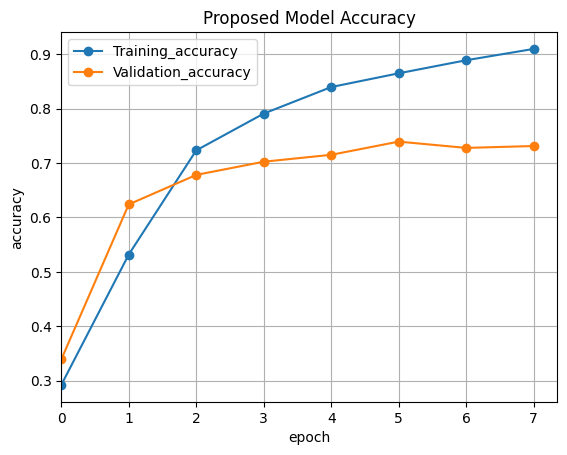

In [93]:
plt.plot(history_1.epoch, history_1.history['accuracy'], '-o', label='Training_accuracy')
plt.plot(history_1.epoch, history_1.history['val_accuracy'], '-o', label='Validation_accuracy')
plt.title('Proposed Model Accuracy')

plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()
plt.close()

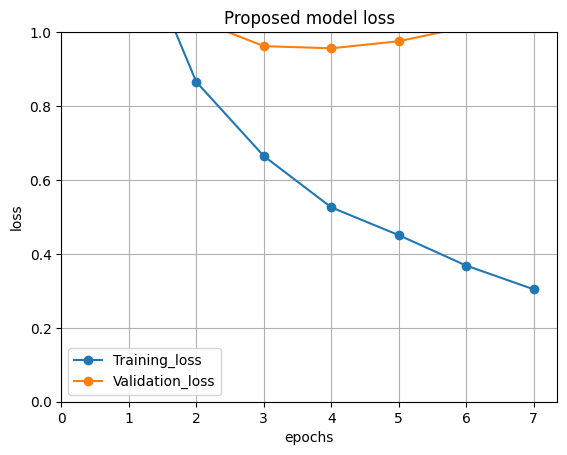

In [94]:
plt.plot(history_1.epoch, history_1.history['loss'], '-o', label='Training_loss')
plt.plot(history_1.epoch, history_1.history['val_loss'], '-o', label='Validation_loss')
plt.title('Proposed model loss')

plt.legend()
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
plt.close()

## CNN-BiLSTM MODEL

In [95]:
# %%time
X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate = temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)


{'จ่าย': 1, 'ลงทะเบียน': 2, 'สํา': 3, 'ไหม': 4, 'หรับ': 5, 'เอกสาร': 6, 'ถาม': 7, 'ต้องการ': 8, 'นักเรียน': 9, 'สวัสดี': 10, 'เงิน': 11, 'พี่': 12, 'ภาคการศึกษา': 13, 'อ่ะ': 14, 'ออนไลน์': 15, 'ใบรับรอง': 16, 'วันที่': 17, 'เทอม': 18, 'วิชา': 19, 'การศึกษา': 20, 'ระ': 21, 'กี่': 22, 'ชํา': 23, 'ระดับ': 24, 'เรียน': 25, '2': 26, 'นะคะ': 27, 'ถอน': 28, 'รู้': 29, '1': 30, 'เรื่อง': 31, 'ดังนั้น': 32, 'ปี': 33, 'คํา': 34, 'ติดต่อ': 35, 'มหาวิทยาลัย': 36, 'ตอนนี้': 37, 'ที่จะ': 38, 'บัณฑิตศึกษา': 39, 'ดี': 40, 'เกรด': 41, 'ระบบ': 42, 'รอ': 43, 'โควต้า': 44, '3': 45, 'ํา': 46, 'สถานะ': 47, 'อยากรู้': 48, 'ใบเสร็จ': 49, 'ข้อมูล': 50, 'ชื่อ': 51, 'ตรวจสอบ': 52, 'ฤดูร้อน': 53, 'นายทะเบียน': 54, 'เวลา': 55, 'บอ': 56, 'จบ': 57, 'ค่าธรรมเนียม': 58, 'เว็บไซต์': 59, 'กํา': 60, 'รหัส': 61, 'จํา': 62, 'ลัง': 63, 'แจ้ง': 64, 'เดือน': 65, 'ใด': 66, 'เหรอ': 67, 'ฮัลโหล': 68, 'ชั้นเรียน': 69, 'บัตร': 70, 'ใบอนุญาต': 71, 'คําขอ': 72, 'ขอบคุณ': 73, 'บัณฑิต': 74, 'ตอน': 75, 'ทราบ': 76, '64': 77, 'โมง': 78, 

In [96]:
# # check the shape of each set
# print("X_train shape: {}".format(X_train.shape))
# print("y_train shape: {}".format(y_train.shape))

# # print("X_train_sub shape: {}".format(X_train_sub.shape))
# # print("y_train_sub shape: {}".format(y_train_sub.shape))

# # print("X_val shape: {}".format(X_val.shape))
# # print("y_val shape: {}".format(y_val.shape))

# print("X_test_unseen shape: {}".format(X_test_unseen.shape))
# print("y_test_unseen shape: {}".format(y_test_unseen.shape))

In [97]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test_unseen)))

Train set size = 4040 
Test set size = 1444


In [98]:
import tensorflow as tf

def build_model_2(lr=0.0, lr_d=0.0, spatial_dr=0.0, kernel_size=3,
                  dense_units=128, dropout_ratio=0.0, num_filters=32,
                  lstm_units_1=0, lstm_units_2=0, batch_size=64, epochs=10):
    
    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(MAX_NB_WORDS, embed_dim, input_length=max_length)(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spatial_dr)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
    x = Dense(dense_units, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
#     x = AttentionWithContext()(x)
#     x = Dense(64, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(7, activation="softmax")(x)
    model = Model(model_input, model_output)
    
    ######################## COMPILING THE MODEL ##################################
    model.compile(
        loss = "categorical_crossentropy", 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, decay=lr_d),
        # optimizer='adam',
        metrics = [
            "accuracy",
#             "binary_accuracy",
#              'categorical_accuracy' ,
#             tf.keras.metrics.AUC(),
#             tf.keras.metrics.Precision(),
#             tf.keras.metrics.Recall()
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
    model_path = "saved_model/best_CNN_BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".hdf5"
    check_point = ModelCheckpoint(model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1)
    
    # Display a summary of the models structure
    print(model.summary())
    print("#"*80)
    tf.keras.utils.plot_model(model, to_file="cnn_BiLSTM_architecture_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".png", show_shapes=True)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history = model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_validate, y_validate),
        callbacks=[check_point,early_stop])
    train_time = time() - start_time
    print(train_time)

#     model = load_model(model_path)
    model = load_model(model_path, custom_objects=create_custom_objects())
    
    ######################## EVALUATING THE MODEL ##################################  
    model.evaluate(X_test_unseen, y_test_unseen) # or model.predict
    
    return model, history, train_time

In [99]:
# Train proposed model
model_2, history_5, train_time = build_model_2(lr=learning_rate, lr_d=learning_decay, spatial_dr=spa_dropout_ratio, kernel_size=kernel_size,
                                            dense_units=dense_units, dropout_ratio=dropout_ratio, num_filters=num_filters, lstm_units_1=lstm_units_1,
                                            lstm_units_2=lstm_units_2, batch_size=batch_size, epochs=epochs
                                           )

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 45)]              0         
                                                                 
 embedding_11 (Embedding)    (None, 45, 300)           852300    
                                                                 
 spatial_dropout1d_33 (Spat  (None, 45, 300)           0         
 ialDropout1D)                                                   
                                                                 
 conv1d_33 (Conv1D)          (None, 43, 50)            45050     
                                                                 
 max_pooling1d_33 (MaxPooli  (None, 21, 50)            0         
 ng1D)                                                           
                                                                 
 dropout_66 (Dropout)        (None, 21, 50)            0  

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


64/64 [==============================] - ETA: 0s - loss: 1.3426 - accuracy: 0.5141
Epoch 2: val_loss improved from 1.62066 to 1.14517, saving model to saved_model/best_CNN_BiLSTM_20240210_13-44-14.hdf5
64/64 [==============================] - 3s 49ms/step - loss: 1.3426 - accuracy: 0.5141 - val_loss: 1.1452 - val_accuracy: 0.6205
Epoch 3/10
64/64 [==============================] - ETA: 0s - loss: 0.9471 - accuracy: 0.6770
Epoch 3: val_loss improved from 1.14517 to 0.99729, saving model to saved_model/best_CNN_BiLSTM_20240210_13-44-14.hdf5
64/64 [==============================] - 3s 47ms/step - loss: 0.9471 - accuracy: 0.6770 - val_loss: 0.9973 - val_accuracy: 0.6609
Epoch 4/10
63/64 [============================>.] - ETA: 0s - loss: 0.7432 - accuracy: 0.7607
Epoch 4: val_loss improved from 0.99729 to 0.98689, saving model to saved_model/best_CNN_BiLSTM_20240210_13-44-14.hdf5
64/64 [==============================] - 3s 52ms/step - loss: 0.7433 - accuracy: 0.7606 - val_loss: 0.9869 - val

In [100]:
# Test 15%
predicted = model_2.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)


28/28 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0     0.7258    0.8158    0.7681       266
           1     0.8606    0.8304    0.8452       171
           2     0.3500    0.4000    0.3733        35
           3     0.7605    0.8734    0.8130       229
           4     0.0000    0.0000    0.0000        31
           5     0.7500    0.1071    0.1875        28
           6     0.5729    0.5140    0.5419       107

    accuracy                         0.7278       867
   macro avg     0.5742    0.5058    0.5042       867
weighted avg     0.7023    0.7278    0.7051       867

Testing Accuracy: 0.727797
Testing Precision: 0.702319
Testing Recall: 0.727797
Testing F1 score: 0.705118


/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

In [101]:
df_results.loc['CNN-BiLSTM Test 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.735481,0.743652,0.738178,0.738178,24.835193
Att-Based CNN-BiLSTM Validate 15%,0.712302,0.733879,0.715110,0.715110,24.835193
Att-Based CNN-BiLSTM Test unseen 20%,0.708974,0.725424,0.710526,0.710526,24.835193
CNN-BiLSTM Test 15%,0.705118,0.702319,0.727797,0.727797,28.531677


In [102]:
# Validate 15%
predicted_val = model_2.predict(X_validate)

predicted_val = np.argmax(predicted_val, axis=1)
y_validate = np.argmax(y_validate,axis=1)

report = classification_report(y_validate, predicted_val, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_validate, predicted_val)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_validate, predicted_val,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_validate, predicted_val,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_validate, predicted_val,average='weighted')
print('Testing F1 score: %f' % f1)

28/28 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0     0.7199    0.8308    0.7714       266
           1     0.7976    0.7836    0.7906       171
           2     0.5000    0.3429    0.4068        35
           3     0.7112    0.8640    0.7802       228
           4     0.0000    0.0000    0.0000        31
           5     0.5000    0.0345    0.0645        29
           6     0.6517    0.5421    0.5918       107

    accuracy                         0.7186       867
   macro avg     0.5543    0.4854    0.4865       867
weighted avg     0.6825    0.7186    0.6894       867

Testing Accuracy: 0.718570
Testing Precision: 0.682538
Testing Recall: 0.718570
Testing F1 score: 0.689380


/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

In [103]:

df_results.loc['CNN-BiLSTM Validate 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.735481,0.743652,0.738178,0.738178,24.835193
Att-Based CNN-BiLSTM Validate 15%,0.712302,0.733879,0.715110,0.715110,24.835193
Att-Based CNN-BiLSTM Test unseen 20%,0.708974,0.725424,0.710526,0.710526,24.835193
CNN-BiLSTM Test 15%,0.705118,0.702319,0.727797,0.727797,28.531677
CNN-BiLSTM Validate 15%,0.689380,0.682538,0.718570,0.718570,28.531677


In [104]:
# Test unseen 15%

predicted = model_2.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

46/46 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

           0     0.6998    0.8104    0.7510       443
           1     0.8561    0.7930    0.8233       285
           2     0.4082    0.3448    0.3738        58
           3     0.7494    0.8421    0.7931       380
           4     0.0000    0.0000    0.0000        52
           5     0.5000    0.0833    0.1429        48
           6     0.5464    0.5618    0.5540       178

    accuracy                         0.7126      1444
   macro avg     0.5371    0.4908    0.4912      1444
weighted avg     0.6812    0.7126    0.6897      1444

Testing Accuracy: 0.712604
Testing Precision: 0.681239
Testing Recall: 0.712604
Testing F1 score: 0.689665


/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted s

In [105]:

# append the results
df_results.loc['CNN-BiLSTM Test unseen 20%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.735481,0.743652,0.738178,0.738178,24.835193
Att-Based CNN-BiLSTM Validate 15%,0.712302,0.733879,0.715110,0.715110,24.835193
Att-Based CNN-BiLSTM Test unseen 20%,0.708974,0.725424,0.710526,0.710526,24.835193
CNN-BiLSTM Test 15%,0.705118,0.702319,0.727797,0.727797,28.531677
CNN-BiLSTM Validate 15%,0.689380,0.682538,0.718570,0.718570,28.531677
CNN-BiLSTM Test unseen 20%,0.689665,0.681239,0.712604,0.712604,28.531677


In [106]:
# %%time
X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate = temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)


{'จ่าย': 1, 'ลงทะเบียน': 2, 'สํา': 3, 'ไหม': 4, 'หรับ': 5, 'เอกสาร': 6, 'ถาม': 7, 'ต้องการ': 8, 'นักเรียน': 9, 'สวัสดี': 10, 'เงิน': 11, 'พี่': 12, 'ภาคการศึกษา': 13, 'อ่ะ': 14, 'ออนไลน์': 15, 'ใบรับรอง': 16, 'วันที่': 17, 'เทอม': 18, 'วิชา': 19, 'การศึกษา': 20, 'ระ': 21, 'กี่': 22, 'ชํา': 23, 'ระดับ': 24, 'เรียน': 25, '2': 26, 'นะคะ': 27, 'ถอน': 28, 'รู้': 29, '1': 30, 'เรื่อง': 31, 'ดังนั้น': 32, 'ปี': 33, 'คํา': 34, 'ติดต่อ': 35, 'มหาวิทยาลัย': 36, 'ตอนนี้': 37, 'ที่จะ': 38, 'บัณฑิตศึกษา': 39, 'ดี': 40, 'เกรด': 41, 'ระบบ': 42, 'รอ': 43, 'โควต้า': 44, '3': 45, 'ํา': 46, 'สถานะ': 47, 'อยากรู้': 48, 'ใบเสร็จ': 49, 'ข้อมูล': 50, 'ชื่อ': 51, 'ตรวจสอบ': 52, 'ฤดูร้อน': 53, 'นายทะเบียน': 54, 'เวลา': 55, 'บอ': 56, 'จบ': 57, 'ค่าธรรมเนียม': 58, 'เว็บไซต์': 59, 'กํา': 60, 'รหัส': 61, 'จํา': 62, 'ลัง': 63, 'แจ้ง': 64, 'เดือน': 65, 'ใด': 66, 'เหรอ': 67, 'ฮัลโหล': 68, 'ชั้นเรียน': 69, 'บัตร': 70, 'ใบอนุญาต': 71, 'คําขอ': 72, 'ขอบคุณ': 73, 'บัณฑิต': 74, 'ตอน': 75, 'ทราบ': 76, '64': 77, 'โมง': 78, 

In [107]:

# Number of folds
num_folds = 10

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_scores_cnn_bilstm = []
precision_scores_cnn_bilstm = []
f1_scores_cnn_bilstm = []
recall_scores_cnn_bilstm = []

X, y_encoded = X_train, y_train
total_train_time = 0  # Initialize total training time

# Perform cross-validation
fold_var = 1
for i, (train_index, test_index) in enumerate(kf.split(X, y_encoded.argmax(1))):
    fold_var +=1
    print("------ Fold ----------", fold_var)
    
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]

    model_input = Input(shape=(max_length,))
    
    ######################## EMBEDDING LAYER ###############################################
    # embed MAX_NB_WORDS words into a embed_dim vector. (e.g. For fasttext, the embed__dim is 300)
    x = Embedding(MAX_NB_WORDS, embed_dim, input_length=max_length)(model_input)
            
    # dropout operation
#     x = Dropout(dropout_ratio)(x)
    x = SpatialDropout1D(spa_dropout_ratio)(x)
    
    ######################## CNN LAYER(S) ###############################################
    ## one kernel
#     conv = Conv1D(
#         filters = num_filters,
#         kernel_size=,
#         padding = "valid",
# #         kernel_initializer='he_uniform',
# #         kernel_initializer='he_normal',
#         activation = "relu",
#         strides=1
#     )(x)
    conv = Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(conv)
    
#     ## multiple kernels
#     maxpool_pool = []
#     for sz in kernel_size:
#         print("kernel ... ",sz)
#         conv = Conv1D(
#             filters = num_filters,
#             kernel_size = sz,
# #             padding = "valid",
#             padding = "same", # Use 'same' padding so outputs have the same shape as inputs.
#             kernel_initializer='he_uniform',
# #             kernel_initializer='he_normal',
#             activation = "relu",
#             strides = 1
#         )(x)
        
#         ## pooling operations
# #         conv = GlobalMaxPooling1D()(conv)
# #         conv = GlobalAveragePooling1D()(conv)
# #         conv = MaxPool1D(pool_size=(maxlen - filter_sizes[sz] + 1, 1))(conv)
# #         maxpool_pool.append(conv)

#         maxpool_pool.append(GlobalMaxPooling1D()(conv))
#         maxpool_pool.append(GlobalAveragePooling1D()(conv))

#     ## Concatenates each maxpooled result and send it to the BiLSTM layer
# #     x = concatenate()(maxpool_pool) if len(maxpool_pool) > 1 else maxpool_pool[0]
#     x = Concatenate(axis=1)(maxpool_pool)
# #     x = concatenate(maxpool_pool)  # yes or no
    
# #     x = BatchNormalization()(x) # yes or no
# #     x = Flatten()(x) # yes or no
    
    x = Dropout(dropout_ratio)(x) # yes or no
    
#     x = Dense(dense_units, activation = "relu")(x) # yes or no  
#     x = BatchNormalization()(x) # yes or no
    
    ######################## BiLSTM LAYER(S) ################################################
#     x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # CuDNNLSTm can be implemented instead of LSTM, it is just implementations of LSTM that are created to run faster on GPUs
    x = Bidirectional(LSTM(lstm_units_1, return_sequences=True))(x)
    x = Bidirectional(LSTM(lstm_units_2))(x) # yes or no
#     avg_pool = GlobalAveragePooling1D()(x)  # yes or no
#     max_pool = GlobalMaxPooling1D()(x)  # yes or no
#     x = concatenate([avg_pool, max_pool])  # yes or no
    x = Dense(dense_units, activation="relu")(x)

#     x = Dropout(dropout_ratio)(x) # yes or no    

#     x = Bidirectional(LSTM(64, return_sequences=True))(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
#     x = Dropout(0.1)(conc)
    
    ######################## ATTENTION LAYER ################################################
    # use Attention operation, with a context/query vector, for temporal data.
#     x = AttentionWithContext()(x)
#     x = Dense(64, activation='relu')(x)  
    x = Dropout(dropout_ratio)(x)

    # The attention using Bahdanau attention.
#     attention = BahdanauAttention(lstm_units_2) # Weight Size Definition
#     context_vector, attention_weights = attention(lstm, state_h)

    # use Attention mechanism for temporal data.
#     x = Attention(max_length)(x)
#     x = GlobalMaxPooling1D()(x) # yes or no    
#     x = GlobalAveragePooling1D()(x) # yes or no    
#     x = Dropout(dropout_ratio)(x)
#     x = Dense(64, activation='relu')(x)
#     x = Dropout(dropout_ratio)(x)

    ######################## CLASSIFICATION LAYER ###########################################
    model_output = Dense(7, activation="softmax")(x)
    cnn_bisltm_model = Model(model_input, model_output)
    
    ######################## COMPILING THE MODEL ##################################
    cnn_bisltm_model.compile(
        loss = "categorical_crossentropy", 
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
        # optimizer='adam',
        metrics = [
            "accuracy",
#             "binary_accuracy",
#              'categorical_accuracy' ,
#             tf.keras.metrics.AUC(),
#             tf.keras.metrics.Precision(),
#             tf.keras.metrics.Recall()
            ]
        )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT #################################
    check_point = ModelCheckpoint(cnn_bilstm_cross_validate_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1)
    
    # Display a summary of the models structure
    print(cnn_bisltm_model.summary())
    print("#"*80)
    # tf.keras.utils.plot_model(cnn_bisltm_model, to_file="cnn_BiLSTM_architecture_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".png", show_shapes=True)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history = cnn_bisltm_model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),
        callbacks=[check_point,early_stop])
    total_train_time += train_time
    
    y_pred=np.argmax(cnn_bisltm_model.predict(X_val), axis=-1)
    y_true_validation_test = np.argmax(y_val,axis = 1)
    
    accuracy_scores_cnn_bilstm.append(accuracy_score(y_true_validation_test, y_pred))
    precision_scores_cnn_bilstm.append(precision_score(y_true_validation_test, y_pred, average='weighted'))
    f1_scores_cnn_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))
    recall_scores_cnn_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))



------ Fold ---------- 2
Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 45)]              0         
                                                                 
 embedding_12 (Embedding)    (None, 45, 300)           852300    
                                                                 
 spatial_dropout1d_34 (Spat  (None, 45, 300)           0         
 ialDropout1D)                                                   
                                                                 
 conv1d_34 (Conv1D)          (None, 43, 50)            45050     
                                                                 
 max_pooling1d_34 (MaxPooli  (None, 21, 50)            0         
 ng1D)                                                           
                                                                 
 dropout_68 (Dropout)        (Non

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/57 [============================>.] - ETA: 0s - loss: 1.3451 - accuracy: 0.5011
Epoch 2: val_loss improved from 1.59604 to 1.17697, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 40ms/step - loss: 1.3421 - accuracy: 0.5019 - val_loss: 1.1770 - val_accuracy: 0.5272
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.9322 - accuracy: 0.6958
Epoch 3: val_loss improved from 1.17697 to 0.96235, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 52ms/step - loss: 0.9322 - accuracy: 0.6958 - val_loss: 0.9624 - val_accuracy: 0.6881
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.7101 - accuracy: 0.7720
Epoch 4: val_loss improved from 0.96235 to 0.87476, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 50ms/step - loss: 0.7101 - accuracy: 0.7720 - val_loss: 0.8748 - val_ac

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - ETA: 0s - loss: 1.3573 - accuracy: 0.5121
Epoch 2: val_loss improved from 1.63152 to 1.14994, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 48ms/step - loss: 1.3573 - accuracy: 0.5121 - val_loss: 1.1499 - val_accuracy: 0.6287
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.8986 - accuracy: 0.7159
Epoch 3: val_loss improved from 1.14994 to 1.01872, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 56ms/step - loss: 0.8986 - accuracy: 0.7159 - val_loss: 1.0187 - val_accuracy: 0.6658
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.7734
Epoch 4: val_loss improved from 1.01872 to 0.98512, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 55ms/step - loss: 0.6908 - accuracy: 0.7734 - val_loss: 0.9851 - val_ac

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/57 [============================>.] - ETA: 0s - loss: 1.2268 - accuracy: 0.6032
Epoch 2: val_loss improved from 1.62539 to 0.95467, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 44ms/step - loss: 1.2235 - accuracy: 0.6045 - val_loss: 0.9547 - val_accuracy: 0.7079
Epoch 3/10
56/57 [============================>.] - ETA: 0s - loss: 0.7988 - accuracy: 0.7564
Epoch 3: val_loss improved from 0.95467 to 0.89609, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 3s 51ms/step - loss: 0.7983 - accuracy: 0.7561 - val_loss: 0.8961 - val_accuracy: 0.7104
Epoch 4/10
56/57 [============================>.] - ETA: 0s - loss: 0.6379 - accuracy: 0.8044
Epoch 4: val_loss did not improve from 0.89609
57/57 [==============================] - 3s 54ms/step - loss: 0.6410 - accuracy: 0.8034 - val_loss: 0.9342 - val_accuracy: 0.7030
Epoch 5/10
56/57 [============================>.] - ETA:

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/57 [===========================>..] - ETA: 0s - loss: 1.2691 - accuracy: 0.5591
Epoch 2: val_loss improved from 1.55010 to 1.08932, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 30ms/step - loss: 1.2621 - accuracy: 0.5611 - val_loss: 1.0893 - val_accuracy: 0.6485
Epoch 3/10
56/57 [============================>.] - ETA: 0s - loss: 0.8788 - accuracy: 0.7165
Epoch 3: val_loss improved from 1.08932 to 1.01670, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 29ms/step - loss: 0.8795 - accuracy: 0.7156 - val_loss: 1.0167 - val_accuracy: 0.6485
Epoch 4/10
56/57 [============================>.] - ETA: 0s - loss: 0.6647 - accuracy: 0.7924
Epoch 4: val_loss improved from 1.01670 to 0.97642, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 37ms/step - loss: 0.6688 - accuracy: 0.7904 - val_loss: 0.9764 - val_ac

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - ETA: 0s - loss: 1.3281 - accuracy: 0.5245
Epoch 2: val_loss improved from 1.64510 to 0.99957, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 38ms/step - loss: 1.3281 - accuracy: 0.5245 - val_loss: 0.9996 - val_accuracy: 0.6757
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.7970 - accuracy: 0.7500
Epoch 3: val_loss improved from 0.99957 to 0.93933, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 33ms/step - loss: 0.7970 - accuracy: 0.7500 - val_loss: 0.9393 - val_accuracy: 0.6931
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.5879 - accuracy: 0.8100
Epoch 4: val_loss improved from 0.93933 to 0.90127, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 42ms/step - loss: 0.5879 - accuracy: 0.8100 - val_loss: 0.9013 - val_ac

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - ETA: 0s - loss: 1.2204 - accuracy: 0.5930
Epoch 2: val_loss improved from 1.61159 to 1.01721, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 37ms/step - loss: 1.2204 - accuracy: 0.5930 - val_loss: 1.0172 - val_accuracy: 0.6658
Epoch 3/10
56/57 [============================>.] - ETA: 0s - loss: 0.8116 - accuracy: 0.7455
Epoch 3: val_loss improved from 1.01721 to 0.95110, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 37ms/step - loss: 0.8075 - accuracy: 0.7472 - val_loss: 0.9511 - val_accuracy: 0.6955
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.6427 - accuracy: 0.7968
Epoch 4: val_loss did not improve from 0.95110
57/57 [==============================] - 2s 37ms/step - loss: 0.6427 - accuracy: 0.7968 - val_loss: 0.9540 - val_accuracy: 0.7129
Epoch 5/10
56/57 [============================>.] - ETA:

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - ETA: 0s - loss: 1.3901 - accuracy: 0.5058
Epoch 2: val_loss improved from 1.64167 to 1.08854, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 37ms/step - loss: 1.3901 - accuracy: 0.5058 - val_loss: 1.0885 - val_accuracy: 0.6386
Epoch 3/10
56/57 [============================>.] - ETA: 0s - loss: 0.8555 - accuracy: 0.7193
Epoch 3: val_loss improved from 1.08854 to 0.92703, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 38ms/step - loss: 0.8533 - accuracy: 0.7200 - val_loss: 0.9270 - val_accuracy: 0.7129
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.6103 - accuracy: 0.8036
Epoch 4: val_loss did not improve from 0.92703
57/57 [==============================] - 2s 37ms/step - loss: 0.6103 - accuracy: 0.8036 - val_loss: 0.9372 - val_accuracy: 0.7104
Epoch 5/10
57/57 [==============================] - ETA:

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - ETA: 0s - loss: 1.2204 - accuracy: 0.5833
Epoch 2: val_loss improved from 1.60507 to 0.98050, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 33ms/step - loss: 1.2204 - accuracy: 0.5833 - val_loss: 0.9805 - val_accuracy: 0.6757
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.7983 - accuracy: 0.7486
Epoch 3: val_loss improved from 0.98050 to 0.83170, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 32ms/step - loss: 0.7983 - accuracy: 0.7486 - val_loss: 0.8317 - val_accuracy: 0.7302
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.6018 - accuracy: 0.8075
Epoch 4: val_loss improved from 0.83170 to 0.76514, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 40ms/step - loss: 0.6018 - accuracy: 0.8075 - val_loss: 0.7651 - val_ac

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/57 [============================>.] - ETA: 0s - loss: 1.2938 - accuracy: 0.5505
Epoch 2: val_loss improved from 1.56189 to 1.14427, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 36ms/step - loss: 1.2895 - accuracy: 0.5523 - val_loss: 1.1443 - val_accuracy: 0.5965
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.9314 - accuracy: 0.6898
Epoch 3: val_loss improved from 1.14427 to 0.98215, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 37ms/step - loss: 0.9314 - accuracy: 0.6898 - val_loss: 0.9822 - val_accuracy: 0.6782
Epoch 4/10
56/57 [============================>.] - ETA: 0s - loss: 0.7072 - accuracy: 0.7751
Epoch 4: val_loss improved from 0.98215 to 0.95938, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 39ms/step - loss: 0.7052 - accuracy: 0.7759 - val_loss: 0.9594 - val_ac

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/57 [============================>.] - ETA: 0s - loss: 1.4468 - accuracy: 0.4509
Epoch 2: val_loss improved from 1.64656 to 1.29352, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 28ms/step - loss: 1.4431 - accuracy: 0.4532 - val_loss: 1.2935 - val_accuracy: 0.5495
Epoch 3/10
56/57 [============================>.] - ETA: 0s - loss: 1.0921 - accuracy: 0.6459
Epoch 3: val_loss improved from 1.29352 to 1.10860, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 28ms/step - loss: 1.0931 - accuracy: 0.6449 - val_loss: 1.1086 - val_accuracy: 0.6386
Epoch 4/10
55/57 [===========================>..] - ETA: 0s - loss: 0.8446 - accuracy: 0.7395
Epoch 4: val_loss improved from 1.10860 to 1.02628, saving model to saved_model/best_CNN_BiLSTM_Cross_validation.hdf5
57/57 [==============================] - 2s 28ms/step - loss: 0.8484 - accuracy: 0.7398 - val_loss: 1.0263 - val_ac

In [108]:
accuracy_avg_cnn_bilstm = sum(accuracy_scores_cnn_bilstm) / len(accuracy_scores_cnn_bilstm)
precision_avg_cnn_bilstm = sum(precision_scores_cnn_bilstm) / len(precision_scores_cnn_bilstm)
recall_avg_cnn_bilstm = sum(recall_scores_cnn_bilstm) / len(recall_scores_cnn_bilstm)
f1_avg_cnn_bilstm = sum(f1_scores_cnn_bilstm) / len(f1_scores_cnn_bilstm)

results_df = pd.DataFrame({
    'Fold': list(range(1, num_folds+1)),
    'Accuracy': accuracy_scores_cnn_bilstm,
    'Precision': precision_scores_cnn_bilstm,
    'Recall': recall_scores_cnn_bilstm,
    'F1 Score': f1_scores_cnn_bilstm
 
})
results_df.loc[num_folds] = ['Avg.', accuracy_avg_cnn_bilstm,precision_avg_cnn_bilstm,recall_avg_cnn_bilstm,f1_avg_cnn_bilstm]
print(results_df.to_markdown(index=False))

| Fold   |   Accuracy |   Precision |   Recall |   F1 Score |
|:-------|-----------:|------------:|---------:|-----------:|
| 1      |   0.74505  |    0.736173 | 0.739761 |   0.739761 |
| 2      |   0.75495  |    0.757609 | 0.754523 |   0.754523 |
| 3      |   0.732673 |    0.72493  | 0.722896 |   0.722896 |
| 4      |   0.715347 |    0.712961 | 0.708429 |   0.708429 |
| 5      |   0.717822 |    0.72192  | 0.715877 |   0.715877 |
| 6      |   0.717822 |    0.728223 | 0.714399 |   0.714399 |
| 7      |   0.75     |    0.74931  | 0.746189 |   0.746189 |
| 8      |   0.767327 |    0.770079 | 0.767414 |   0.767414 |
| 9      |   0.74505  |    0.75289  | 0.746919 |   0.746919 |
| 10     |   0.730198 |    0.742489 | 0.735155 |   0.735155 |
| Avg.   |   0.737624 |    0.739658 | 0.735156 |   0.735156 |


In [109]:
df_results_cross_val.loc['CNN-BiLSTM avg cross validation data train 80%'] = [f1_avg_cnn_bilstm, precision_avg_cnn_bilstm, recall_avg_cnn_bilstm, accuracy_avg_cnn_bilstm, total_train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.733744,0.740093,0.733744,0.735149,248.351932
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.735687,0.737849,0.738920,0.738920,24.835193
CNN-BiLSTM avg cross validation data train 80%,0.735156,0.739658,0.735156,0.737624,285.316770


In [111]:
# Test cross validation 20%
model_bilstm_cross_validate = load_model(cnn_bilstm_cross_validate_model_path)
predicted = model_bilstm_cross_validate.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
# print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

46/46 [==============================] - 3s 18ms/step
Testing Accuracy: 0.704986
Testing Precision: 0.715475
Testing Recall: 0.704986
Testing F1 score: 0.708535


In [112]:
df_results_cross_val.loc['CNN-BiLSTM avg cross validation data test 20%'] = [f1, precision, recall, accuracy, train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.733744,0.740093,0.733744,0.735149,248.351932
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.735687,0.737849,0.738920,0.738920,24.835193
CNN-BiLSTM avg cross validation data train 80%,0.735156,0.739658,0.735156,0.737624,285.316770
CNN-BiLSTM avg cross validation data test 20%,0.708535,0.715475,0.704986,0.704986,28.531677


### Plotting the results

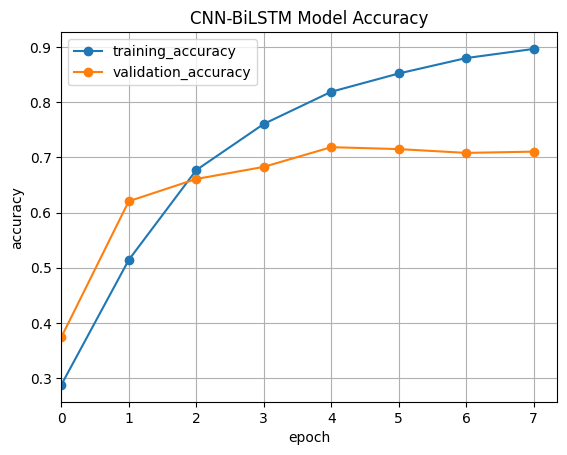

In [113]:
# summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()


plt.plot(history_5.epoch, history_5.history['accuracy'], '-o', label='training_accuracy')
plt.plot(history_5.epoch, history_5.history['val_accuracy'], '-o', label='validation_accuracy')
plt.title('CNN-BiLSTM Model Accuracy')

plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('CNN-BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('CNN-BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

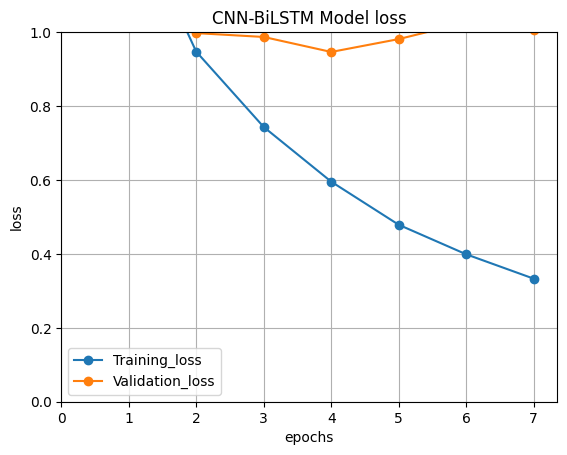

In [114]:
# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.plot(history_5.epoch, history_5.history['loss'], '-o', label='Training_loss')
plt.plot(history_5.epoch, history_5.history['val_loss'], '-o', label='Validation_loss')
plt.title('CNN-BiLSTM Model loss')

plt.legend()
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.savefig('CNN-BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('CNN-BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

# BASELINES MODELS

## 1D CNN MODEL

In [115]:
# %%time
X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate = temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

# ### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)


{'จ่าย': 1, 'ลงทะเบียน': 2, 'สํา': 3, 'ไหม': 4, 'หรับ': 5, 'เอกสาร': 6, 'ถาม': 7, 'ต้องการ': 8, 'นักเรียน': 9, 'สวัสดี': 10, 'เงิน': 11, 'พี่': 12, 'ภาคการศึกษา': 13, 'อ่ะ': 14, 'ออนไลน์': 15, 'ใบรับรอง': 16, 'วันที่': 17, 'เทอม': 18, 'วิชา': 19, 'การศึกษา': 20, 'ระ': 21, 'กี่': 22, 'ชํา': 23, 'ระดับ': 24, 'เรียน': 25, '2': 26, 'นะคะ': 27, 'ถอน': 28, 'รู้': 29, '1': 30, 'เรื่อง': 31, 'ดังนั้น': 32, 'ปี': 33, 'คํา': 34, 'ติดต่อ': 35, 'มหาวิทยาลัย': 36, 'ตอนนี้': 37, 'ที่จะ': 38, 'บัณฑิตศึกษา': 39, 'ดี': 40, 'เกรด': 41, 'ระบบ': 42, 'รอ': 43, 'โควต้า': 44, '3': 45, 'ํา': 46, 'สถานะ': 47, 'อยากรู้': 48, 'ใบเสร็จ': 49, 'ข้อมูล': 50, 'ชื่อ': 51, 'ตรวจสอบ': 52, 'ฤดูร้อน': 53, 'นายทะเบียน': 54, 'เวลา': 55, 'บอ': 56, 'จบ': 57, 'ค่าธรรมเนียม': 58, 'เว็บไซต์': 59, 'กํา': 60, 'รหัส': 61, 'จํา': 62, 'ลัง': 63, 'แจ้ง': 64, 'เดือน': 65, 'ใด': 66, 'เหรอ': 67, 'ฮัลโหล': 68, 'ชั้นเรียน': 69, 'บัตร': 70, 'ใบอนุญาต': 71, 'คําขอ': 72, 'ขอบคุณ': 73, 'บัณฑิต': 74, 'ตอน': 75, 'ทราบ': 76, '64': 77, 'โมง': 78, 

In [116]:

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test_unseen shape: {}".format(X_test_unseen.shape))
print("y_test_unseen shape: {}".format(y_test_unseen.shape))

X_train shape: (4040, 45)
y_train shape: (4040, 7)
X_test_unseen shape: (1444, 45)
y_test_unseen shape: (1444, 7)


In [117]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test)))

Train set size = 4040 
Test set size = 867


In [118]:
#Model Definition
model_3 = Sequential()
model_3.add(Embedding(MAX_NB_WORDS, embed_dim,input_length=max_length))
# model.add(Dropout(0.25))
model_3.add(SpatialDropout1D(spa_dropout_ratio))

model_3.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu'))
model_3.add(MaxPooling1D(pool_size=2))
# model.add(GlobalMaxPooling1D())
model_3.add(Dense(dense_units, activation='relu'))
model_3.add(Flatten()) # no need if used Global poooling
model_3.add(Dropout(dropout_ratio))

model_3.add(Dense(7, activation='softmax'))
# model.add(Dense(1, activation='sigmoid'))
######################## COMPILING THE MODEL ##################################
model_3.compile(
    loss = "categorical_crossentropy", 
   optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
#         optimizer='adam',
    metrics = [
        "accuracy",
#       "binary_accuracy",
        'categorical_accuracy',
#       tf.keras.metrics.AUC(),
#       tf.keras.metrics.Precision(),
#       tf.keras.metrics.Recall()
        ]
    )

print(model_3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 45, 300)           852300    
                                                                 
 spatial_dropout1d_44 (Spat  (None, 45, 300)           0         
 ialDropout1D)                                                   
                                                                 
 conv1d_44 (Conv1D)          (None, 43, 50)            45050     
                                                                 
 max_pooling1d_44 (MaxPooli  (None, 21, 50)            0         
 ng1D)                                                           
                                                                 
 dense_88 (Dense)            (None, 21, 64)            3264      
                                                                 
 flatten (Flatten)           (None, 1344)              0

In [119]:
checkpoint = ModelCheckpoint("saved_model/"+"1D_CNN_"+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + ".h5", monitor='loss', verbose=1, save_best_only=True, mode='min')
earlystopping = EarlyStopping(
    monitor = 'loss',
    verbose = 1, 
    patience = 3, # Number of epochs with no improvement after which training will be stopped.
    mode = 'min'
)
callbacks_list = [checkpoint, earlystopping]

# fit network
start_time = time()
history_2 = model_3.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,callbacks=callbacks_list,validation_data=(X_validate, y_validate))
train_time = time() - start_time
print(train_time)

Epoch 1/10


63/64 [============================>.] - ETA: 0s - loss: 1.6521 - accuracy: 0.3671 - categorical_accuracy: 0.3671
Epoch 1: loss improved from inf to 1.65173, saving model to saved_model/1D_CNN_20240210_14:22:58.h5
64/64 [==============================] - 6s 80ms/step - loss: 1.6517 - accuracy: 0.3671 - categorical_accuracy: 0.3671 - val_loss: 1.4741 - val_accuracy: 0.4602 - val_categorical_accuracy: 0.4602
Epoch 2/10
 1/64 [..............................] - ETA: 2s - loss: 1.5241 - accuracy: 0.4688 - categorical_accuracy: 0.4688

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/64 [============================>.] - ETA: 0s - loss: 1.1009 - accuracy: 0.6493 - categorical_accuracy: 0.6493
Epoch 2: loss improved from 1.65173 to 1.10056, saving model to saved_model/1D_CNN_20240210_14:22:58.h5
64/64 [==============================] - 5s 74ms/step - loss: 1.1006 - accuracy: 0.6490 - categorical_accuracy: 0.6490 - val_loss: 1.0207 - val_accuracy: 0.6932 - val_categorical_accuracy: 0.6932
Epoch 3/10
63/64 [============================>.] - ETA: 0s - loss: 0.7289 - accuracy: 0.7688 - categorical_accuracy: 0.7688
Epoch 3: loss improved from 1.10056 to 0.72846, saving model to saved_model/1D_CNN_20240210_14:22:58.h5
64/64 [==============================] - 4s 70ms/step - loss: 0.7285 - accuracy: 0.7691 - categorical_accuracy: 0.7691 - val_loss: 0.9151 - val_accuracy: 0.7209 - val_categorical_accuracy: 0.7209
Epoch 4/10
63/64 [============================>.] - ETA: 0s - loss: 0.5067 - accuracy: 0.8385 - categorical_accuracy: 0.8385
Epoch 4: loss improved from 0.72846 

In [120]:
# Test 15%
predicted = model_3.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

28/28 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

           0     0.7447    0.7895    0.7664       266
           1     0.8476    0.8129    0.8299       171
           2     0.8148    0.6286    0.7097        35
           3     0.8000    0.8559    0.8270       229
           4     0.6818    0.4839    0.5660        31
           5     0.5926    0.5714    0.5818        28
           6     0.6000    0.5607    0.5797       107

    accuracy                         0.7589       867
   macro avg     0.7259    0.6718    0.6944       867
weighted avg     0.7574    0.7589    0.7565       867

Testing Accuracy: 0.758939
Testing Precision: 0.757400
Testing Recall: 0.758939
Testing F1 score: 0.756474


In [121]:

df_results.loc['1D_CNN Test 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.735481,0.743652,0.738178,0.738178,24.835193
Att-Based CNN-BiLSTM Validate 15%,0.712302,0.733879,0.715110,0.715110,24.835193
Att-Based CNN-BiLSTM Test unseen 20%,0.708974,0.725424,0.710526,0.710526,24.835193
CNN-BiLSTM Test 15%,0.705118,0.702319,0.727797,0.727797,28.531677
CNN-BiLSTM Validate 15%,0.689380,0.682538,0.718570,0.718570,28.531677
CNN-BiLSTM Test unseen 20%,0.689665,0.681239,0.712604,0.712604,28.531677
1D_CNN Test 15%,0.756474,0.757400,0.758939,0.758939,47.318663


In [122]:
# append the results

predicted = model_3.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)



46/46 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0     0.7465    0.8510    0.7954       443
           1     0.8373    0.7404    0.7858       285
           2     0.7857    0.5690    0.6600        58
           3     0.7938    0.8105    0.8021       380
           4     0.5814    0.4808    0.5263        52
           5     0.5122    0.4375    0.4719        48
           6     0.6012    0.5843    0.5926       178

    accuracy                         0.7472      1444
   macro avg     0.6940    0.6391    0.6620      1444
weighted avg     0.7468    0.7472    0.7444      1444

Testing Accuracy: 0.747230
Testing Precision: 0.746808
Testing Recall: 0.747230
Testing F1 score: 0.744379


In [123]:
df_results.loc['1D_CNN Test unseen 20%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.735481,0.743652,0.738178,0.738178,24.835193
Att-Based CNN-BiLSTM Validate 15%,0.712302,0.733879,0.715110,0.715110,24.835193
Att-Based CNN-BiLSTM Test unseen 20%,0.708974,0.725424,0.710526,0.710526,24.835193
CNN-BiLSTM Test 15%,0.705118,0.702319,0.727797,0.727797,28.531677
CNN-BiLSTM Validate 15%,0.689380,0.682538,0.718570,0.718570,28.531677
CNN-BiLSTM Test unseen 20%,0.689665,0.681239,0.712604,0.712604,28.531677
1D_CNN Test 15%,0.756474,0.757400,0.758939,0.758939,47.318663
1D_CNN Test unseen 20%,0.744379,0.746808,0.747230,0.747230,47.318663


In [124]:
# Validate 15%
predicted_val = model_3.predict(X_validate)

predicted_val = np.argmax(predicted_val, axis=1)
y_validate = np.argmax(y_validate,axis=1)

report = classification_report(y_validate, predicted_val, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_validate, predicted_val)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_validate, predicted_val,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_validate, predicted_val,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_validate, predicted_val,average='weighted')
print('Testing F1 score: %f' % f1)


 9/28 [========>.....................] - ETA: 0s

28/28 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0     0.7855    0.8120    0.7985       266
           1     0.7988    0.7895    0.7941       171
           2     0.6897    0.5714    0.6250        35
           3     0.7673    0.8246    0.7949       228
           4     0.6207    0.5806    0.6000        31
           5     0.5000    0.4138    0.4528        29
           6     0.6562    0.5888    0.6207       107

    accuracy                         0.7520       867
   macro avg     0.6883    0.6544    0.6694       867
weighted avg     0.7481    0.7520    0.7491       867

Testing Accuracy: 0.752018
Testing Precision: 0.748076
Testing Recall: 0.752018
Testing F1 score: 0.749094


In [125]:
df_results.loc['1D_CNN Validate 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.735481,0.743652,0.738178,0.738178,24.835193
Att-Based CNN-BiLSTM Validate 15%,0.712302,0.733879,0.715110,0.715110,24.835193
Att-Based CNN-BiLSTM Test unseen 20%,0.708974,0.725424,0.710526,0.710526,24.835193
CNN-BiLSTM Test 15%,0.705118,0.702319,0.727797,0.727797,28.531677
CNN-BiLSTM Validate 15%,0.689380,0.682538,0.718570,0.718570,28.531677
CNN-BiLSTM Test unseen 20%,0.689665,0.681239,0.712604,0.712604,28.531677
1D_CNN Test 15%,0.756474,0.757400,0.758939,0.758939,47.318663
1D_CNN Test unseen 20%,0.744379,0.746808,0.747230,0.747230,47.318663
1D_CNN Validate 15%,0.749094,0.748076,0.752018,0.752018,47.318663


In [126]:
# Number of folds
num_folds = 10

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_scores_1d_cnn = []
precision_scores_1d_cnn = []
f1_scores_1d_cnn = []
recall_scores_1d_cnn = []

X, y_encoded = X_train, y_train
total_train_time = 0  # Initialize total training time
# Perform cross-validation
fold_var = 1
for i, (train_index, test_index) in enumerate(kf.split(X, y_encoded.argmax(1))):
    fold_var +=1
    print("------ Fold ----------", fold_var)
    
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]

    #Model Definition
    cnn_model = Sequential()
    cnn_model.add(Embedding(MAX_NB_WORDS, embed_dim,input_length=max_length))
    # model.add(Dropout(0.25))
    cnn_model.add(SpatialDropout1D(spa_dropout_ratio))

    cnn_model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=2))
    # model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(dense_units, activation='relu'))
    cnn_model.add(Flatten()) # no need if used Global poooling
    cnn_model.add(Dropout(dropout_ratio))

    cnn_model.add(Dense(7, activation='softmax'))
    # model.add(Dense(1, activation='sigmoid'))
    ######################## COMPILING THE MODEL ##################################
    cnn_model.compile(
        loss = "categorical_crossentropy", 
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
    #         optimizer='adam',
        metrics = [
            "accuracy",
    #       "binary_accuracy",
            'categorical_accuracy',
    #       tf.keras.metrics.AUC(),
    #       tf.keras.metrics.Precision(),
    #       tf.keras.metrics.Recall()
            ]
        )
    
   
    check_point = ModelCheckpoint(cnn_cross_validate_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1,)
    
    ######################## TRAINING THE MODEL ##################################
    start_time = time()
    history = cnn_model.fit(
        X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),
        callbacks=[check_point,early_stop])
    total_train_time += train_time  
    
    y_pred=np.argmax(cnn_model.predict(X_val), axis=-1)
    y_true_validation_test = np.argmax(y_val,axis = 1)
    
    accuracy_scores_1d_cnn.append(accuracy_score(y_true_validation_test, y_pred))
    precision_scores_1d_cnn.append(precision_score(y_true_validation_test, y_pred, average='weighted'))
    f1_scores_1d_cnn.append(f1_score(y_true_validation_test, y_pred, average='weighted'))
    recall_scores_1d_cnn.append(f1_score(y_true_validation_test, y_pred, average='weighted'))


------ Fold ---------- 2
Epoch 1/10
56/57 [============================>.] - ETA: 0s - loss: 1.6629 - accuracy: 0.3211 - categorical_accuracy: 0.3211
Epoch 1: val_loss improved from inf to 1.50726, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 4s 60ms/step - loss: 1.6612 - accuracy: 0.3218 - categorical_accuracy: 0.3218 - val_loss: 1.5073 - val_accuracy: 0.3985 - val_categorical_accuracy: 0.3985
Epoch 2/10
 2/57 [>.............................] - ETA: 4s - loss: 1.3095 - accuracy: 0.5312 - categorical_accuracy: 0.5312

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - ETA: 0s - loss: 1.1252 - accuracy: 0.6438 - categorical_accuracy: 0.6438
Epoch 2: val_loss improved from 1.50726 to 0.91827, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 4s 70ms/step - loss: 1.1252 - accuracy: 0.6438 - categorical_accuracy: 0.6438 - val_loss: 0.9183 - val_accuracy: 0.6782 - val_categorical_accuracy: 0.6782
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.7224 - accuracy: 0.7723 - categorical_accuracy: 0.7723
Epoch 3: val_loss improved from 0.91827 to 0.81279, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 4s 70ms/step - loss: 0.7224 - accuracy: 0.7723 - categorical_accuracy: 0.7723 - val_loss: 0.8128 - val_accuracy: 0.7203 - val_categorical_accuracy: 0.7203
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.5136 - accuracy: 0.8413 - categorical_accuracy: 0.8413
Epoch 4: val_loss impr

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - ETA: 0s - loss: 1.1343 - accuracy: 0.6502 - categorical_accuracy: 0.6502
Epoch 2: val_loss improved from 1.51318 to 1.06933, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 4s 69ms/step - loss: 1.1343 - accuracy: 0.6502 - categorical_accuracy: 0.6502 - val_loss: 1.0693 - val_accuracy: 0.6460 - val_categorical_accuracy: 0.6460
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.7610 - categorical_accuracy: 0.7610
Epoch 3: val_loss improved from 1.06933 to 0.97669, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 3s 52ms/step - loss: 0.7427 - accuracy: 0.7610 - categorical_accuracy: 0.7610 - val_loss: 0.9767 - val_accuracy: 0.6782 - val_categorical_accuracy: 0.6782
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.5334 - accuracy: 0.8298 - categorical_accuracy: 0.8298
Epoch 4: val_loss impr

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - ETA: 0s - loss: 1.2156 - accuracy: 0.6133 - categorical_accuracy: 0.6133
Epoch 2: val_loss improved from 1.56144 to 1.04748, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 4s 75ms/step - loss: 1.2156 - accuracy: 0.6133 - categorical_accuracy: 0.6133 - val_loss: 1.0475 - val_accuracy: 0.6757 - val_categorical_accuracy: 0.6757
Epoch 3/10
56/57 [============================>.] - ETA: 0s - loss: 0.7881 - accuracy: 0.7425 - categorical_accuracy: 0.7425
Epoch 3: val_loss improved from 1.04748 to 0.94068, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 4s 75ms/step - loss: 0.7880 - accuracy: 0.7431 - categorical_accuracy: 0.7431 - val_loss: 0.9407 - val_accuracy: 0.6980 - val_categorical_accuracy: 0.6980
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.5500 - accuracy: 0.8243 - categorical_accuracy: 0.8243
Epoch 4: val_loss impr

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - ETA: 0s - loss: 1.1609 - accuracy: 0.6251 - categorical_accuracy: 0.6251
Epoch 2: val_loss improved from 1.53563 to 1.01831, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 4s 65ms/step - loss: 1.1609 - accuracy: 0.6251 - categorical_accuracy: 0.6251 - val_loss: 1.0183 - val_accuracy: 0.6807 - val_categorical_accuracy: 0.6807
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.7782 - accuracy: 0.7478 - categorical_accuracy: 0.7478
Epoch 3: val_loss improved from 1.01831 to 0.93822, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 4s 68ms/step - loss: 0.7782 - accuracy: 0.7478 - categorical_accuracy: 0.7478 - val_loss: 0.9382 - val_accuracy: 0.6980 - val_categorical_accuracy: 0.6980
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.5466 - accuracy: 0.8350 - categorical_accuracy: 0.8350
Epoch 4: val_loss did 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - ETA: 0s - loss: 1.1316 - accuracy: 0.6444 - categorical_accuracy: 0.6444
Epoch 2: val_loss improved from 1.46170 to 0.96738, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 4s 70ms/step - loss: 1.1316 - accuracy: 0.6444 - categorical_accuracy: 0.6444 - val_loss: 0.9674 - val_accuracy: 0.6683 - val_categorical_accuracy: 0.6683
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.7427 - accuracy: 0.7671 - categorical_accuracy: 0.7671
Epoch 3: val_loss improved from 0.96738 to 0.85172, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 4s 68ms/step - loss: 0.7427 - accuracy: 0.7671 - categorical_accuracy: 0.7671 - val_loss: 0.8517 - val_accuracy: 0.7129 - val_categorical_accuracy: 0.7129
Epoch 4/10
56/57 [============================>.] - ETA: 0s - loss: 0.5143 - accuracy: 0.8329 - categorical_accuracy: 0.8329
Epoch 4: val_loss impr

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/57 [============================>.] - ETA: 0s - loss: 1.1774 - accuracy: 0.6317 - categorical_accuracy: 0.6317
Epoch 2: val_loss improved from 1.56992 to 1.00656, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 4s 71ms/step - loss: 1.1754 - accuracy: 0.6312 - categorical_accuracy: 0.6312 - val_loss: 1.0066 - val_accuracy: 0.6460 - val_categorical_accuracy: 0.6460
Epoch 3/10
57/57 [==============================] - ETA: 0s - loss: 0.7648 - accuracy: 0.7492 - categorical_accuracy: 0.7492
Epoch 3: val_loss improved from 1.00656 to 0.91932, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 3s 48ms/step - loss: 0.7648 - accuracy: 0.7492 - categorical_accuracy: 0.7492 - val_loss: 0.9193 - val_accuracy: 0.7030 - val_categorical_accuracy: 0.7030
Epoch 4/10
57/57 [==============================] - ETA: 0s - loss: 0.5517 - accuracy: 0.8287 - categorical_accuracy: 0.8287
Epoch 4: val_loss impr

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


54/57 [===========================>..] - ETA: 0s - loss: 1.1416 - accuracy: 0.6490 - categorical_accuracy: 0.6490
Epoch 2: val_loss improved from 1.48615 to 1.00744, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 1s 10ms/step - loss: 1.1375 - accuracy: 0.6504 - categorical_accuracy: 0.6504 - val_loss: 1.0074 - val_accuracy: 0.6807 - val_categorical_accuracy: 0.6807
Epoch 3/10
54/57 [===========================>..] - ETA: 0s - loss: 0.7362 - accuracy: 0.7685 - categorical_accuracy: 0.7685
Epoch 3: val_loss improved from 1.00744 to 0.89623, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 1s 16ms/step - loss: 0.7401 - accuracy: 0.7673 - categorical_accuracy: 0.7673 - val_loss: 0.8962 - val_accuracy: 0.7079 - val_categorical_accuracy: 0.7079
Epoch 4/10
54/57 [===========================>..] - ETA: 0s - loss: 0.5257 - accuracy: 0.8330 - categorical_accuracy: 0.8330
Epoch 4: val_loss impr

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


55/57 [===========================>..] - ETA: 0s - loss: 1.1712 - accuracy: 0.6384 - categorical_accuracy: 0.6384
Epoch 2: val_loss improved from 1.48585 to 0.95884, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 1s 10ms/step - loss: 1.1650 - accuracy: 0.6378 - categorical_accuracy: 0.6378 - val_loss: 0.9588 - val_accuracy: 0.6782 - val_categorical_accuracy: 0.6782
Epoch 3/10
54/57 [===========================>..] - ETA: 0s - loss: 0.8154 - accuracy: 0.7376 - categorical_accuracy: 0.7376
Epoch 3: val_loss improved from 0.95884 to 0.83992, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 1s 11ms/step - loss: 0.8062 - accuracy: 0.7409 - categorical_accuracy: 0.7409 - val_loss: 0.8399 - val_accuracy: 0.7401 - val_categorical_accuracy: 0.7401
Epoch 4/10
56/57 [============================>.] - ETA: 0s - loss: 0.5836 - accuracy: 0.8142 - categorical_accuracy: 0.8142
Epoch 4: val_loss impr

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


54/57 [===========================>..] - ETA: 0s - loss: 1.1565 - accuracy: 0.6406 - categorical_accuracy: 0.6406
Epoch 2: val_loss improved from 1.50364 to 0.95021, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 1s 10ms/step - loss: 1.1525 - accuracy: 0.6400 - categorical_accuracy: 0.6400 - val_loss: 0.9502 - val_accuracy: 0.6906 - val_categorical_accuracy: 0.6906
Epoch 3/10
56/57 [============================>.] - ETA: 0s - loss: 0.7774 - accuracy: 0.7427 - categorical_accuracy: 0.7427
Epoch 3: val_loss improved from 0.95021 to 0.88578, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 1s 11ms/step - loss: 0.7790 - accuracy: 0.7420 - categorical_accuracy: 0.7420 - val_loss: 0.8858 - val_accuracy: 0.7351 - val_categorical_accuracy: 0.7351
Epoch 4/10
53/57 [==========================>...] - ETA: 0s - loss: 0.5705 - accuracy: 0.8152 - categorical_accuracy: 0.8152
Epoch 4: val_loss impr

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/57 [============================>.] - ETA: 0s - loss: 1.1581 - accuracy: 0.6356 - categorical_accuracy: 0.6356
Epoch 2: val_loss improved from 1.52980 to 1.00815, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 1s 9ms/step - loss: 1.1592 - accuracy: 0.6353 - categorical_accuracy: 0.6353 - val_loss: 1.0081 - val_accuracy: 0.6510 - val_categorical_accuracy: 0.6510
Epoch 3/10
53/57 [==========================>...] - ETA: 0s - loss: 0.7736 - accuracy: 0.7503 - categorical_accuracy: 0.7503
Epoch 3: val_loss improved from 1.00815 to 0.87361, saving model to saved_model/best_CNN_Cross_validation.hdf5
57/57 [==============================] - 1s 10ms/step - loss: 0.7660 - accuracy: 0.7530 - categorical_accuracy: 0.7530 - val_loss: 0.8736 - val_accuracy: 0.7153 - val_categorical_accuracy: 0.7153
Epoch 4/10
54/57 [===========================>..] - ETA: 0s - loss: 0.5482 - accuracy: 0.8206 - categorical_accuracy: 0.8206
Epoch 4: val_loss impro

In [127]:
accuracy_avg_1d_cnn = sum(accuracy_scores_1d_cnn) / len(accuracy_scores_1d_cnn)
precision_avg_1d_cnn = sum(precision_scores_1d_cnn) / len(precision_scores_1d_cnn)
recall_avg_1d_cnn = sum(recall_scores_1d_cnn) / len(recall_scores_1d_cnn)
f1_avg_1d_cnn = sum(f1_scores_1d_cnn) / len(f1_scores_1d_cnn)

results_df = pd.DataFrame({
    'Fold': list(range(1, num_folds+1)),
    'Accuracy': accuracy_scores_1d_cnn,
    'Precision': precision_scores_1d_cnn,
    'Recall': recall_scores_1d_cnn,
    'F1 Score': f1_scores_1d_cnn
 
})
results_df.loc[num_folds] = ['Avg.', accuracy_avg_1d_cnn,precision_avg_1d_cnn,recall_avg_1d_cnn,f1_avg_1d_cnn]
print(results_df.to_markdown(index=False))

| Fold   |   Accuracy |   Precision |   Recall |   F1 Score |
|:-------|-----------:|------------:|---------:|-----------:|
| 1      |   0.757426 |    0.76662  | 0.755201 |   0.755201 |
| 2      |   0.737624 |    0.741309 | 0.738026 |   0.738026 |
| 3      |   0.730198 |    0.732664 | 0.730626 |   0.730626 |
| 4      |   0.722772 |    0.722061 | 0.716551 |   0.716551 |
| 5      |   0.730198 |    0.74862  | 0.728867 |   0.728867 |
| 6      |   0.725248 |    0.734954 | 0.726487 |   0.726487 |
| 7      |   0.779703 |    0.782181 | 0.77492  |   0.77492  |
| 8      |   0.782178 |    0.775677 | 0.778178 |   0.778178 |
| 9      |   0.740099 |    0.74726  | 0.739417 |   0.739417 |
| 10     |   0.75     |    0.744805 | 0.744689 |   0.744689 |
| Avg.   |   0.745545 |    0.749615 | 0.743296 |   0.743296 |


In [128]:
df_results_cross_val.loc['1D_CNN avg cross validation data test 80%'] = [f1_avg_1d_cnn, precision_avg_1d_cnn, recall_avg_1d_cnn, accuracy_avg_1d_cnn, total_train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.733744,0.740093,0.733744,0.735149,248.351932
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.735687,0.737849,0.738920,0.738920,24.835193
CNN-BiLSTM avg cross validation data train 80%,0.735156,0.739658,0.735156,0.737624,285.316770
CNN-BiLSTM avg cross validation data test 20%,0.708535,0.715475,0.704986,0.704986,28.531677
1D_CNN avg cross validation data test 80%,0.743296,0.749615,0.743296,0.745545,473.186631


In [130]:
# Test cross validation 20%
model_cnn_cross_validate = load_model(cnn_cross_validate_model_path)
predicted = model_cnn_cross_validate.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
# y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
# print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

46/46 [==============================] - 0s 1ms/step
Testing Accuracy: 0.727839
Testing Precision: 0.731146
Testing Recall: 0.727839
Testing F1 score: 0.708742


In [131]:
df_results_cross_val.loc['1D_CNN avg cross validation data test 20%'] = [f1, precision, recall, accuracy, train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.733744,0.740093,0.733744,0.735149,248.351932
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.735687,0.737849,0.738920,0.738920,24.835193
CNN-BiLSTM avg cross validation data train 80%,0.735156,0.739658,0.735156,0.737624,285.316770
CNN-BiLSTM avg cross validation data test 20%,0.708535,0.715475,0.704986,0.704986,28.531677
1D_CNN avg cross validation data test 80%,0.743296,0.749615,0.743296,0.745545,473.186631
1D_CNN avg cross validation data test 20%,0.708742,0.731146,0.727839,0.727839,47.318663


### **Plotting the results**

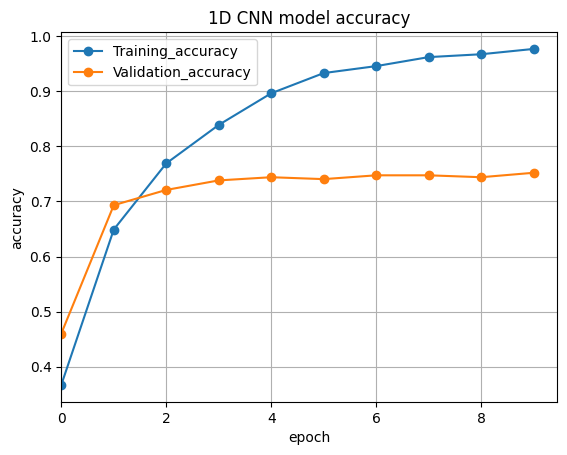

In [132]:
plt.plot(history_2.epoch, history_2.history['accuracy'], '-o', label='Training_accuracy')
plt.plot(history_2.epoch, history_2.history['val_accuracy'], '-o', label='Validation_accuracy')
plt.title('1D CNN model accuracy')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('1D_CNN__accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('1D_CNN__accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

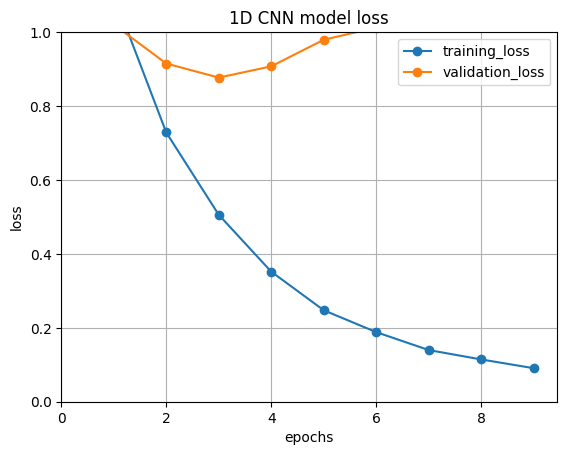

In [133]:
plt.plot(history_2.epoch, history_2.history['loss'], '-o', label='training_loss')
plt.plot(history_2.epoch, history_2.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.title('1D CNN model loss')
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.savefig('1D_CNN__loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('1D_CNN__loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H:%M:%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

## BiLSTM MODEL

In [134]:
# %%time
X_train, X_test_unseen,  X_test, X_validate, y_train, y_test_unseen,y_test,y_validate = temp_X_train, temp_X_test_unseen,temp_X_test,temp_X_validate, temp_y_train, temp_y_test_unseen,temp_y_test,temp_y_validate


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test_unseen = tokenizer.texts_to_sequences(X_test_unseen)
X_test = tokenizer.texts_to_sequences(X_test)
X_validate = tokenizer.texts_to_sequences(X_validate)

vocab_size = len(tokenizer.word_index) + 1
MAX_NB_WORDS = vocab_size
print(tokenizer.word_index)

max_length=max([len(i) for i in X_train])
print('Max len:', max_length)

X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
X_test_unseen = pad_sequences(X_test_unseen, padding='post', maxlen=max_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)
X_validate = pad_sequences(X_validate, padding='post', maxlen=max_length)

y_test_unseen = to_categorical(y_test_unseen)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)

### Cross validation ###
# X_train, y_train = temp_message, temp_label
# tokenizer_cross_val = Tokenizer()
# tokenizer_cross_val.fit_on_texts(X_train)

# X_train = tokenizer_cross_val.texts_to_sequences(X_train)

# vocab_size_cross_val = len(tokenizer_cross_val.word_index) + 1
# MAX_NB_WORDS = vocab_size_cross_val

# X_train = pad_sequences(X_train, padding='post', maxlen=max_length)
# y_train = to_categorical(y_train)


{'จ่าย': 1, 'ลงทะเบียน': 2, 'สํา': 3, 'ไหม': 4, 'หรับ': 5, 'เอกสาร': 6, 'ถาม': 7, 'ต้องการ': 8, 'นักเรียน': 9, 'สวัสดี': 10, 'เงิน': 11, 'พี่': 12, 'ภาคการศึกษา': 13, 'อ่ะ': 14, 'ออนไลน์': 15, 'ใบรับรอง': 16, 'วันที่': 17, 'เทอม': 18, 'วิชา': 19, 'การศึกษา': 20, 'ระ': 21, 'กี่': 22, 'ชํา': 23, 'ระดับ': 24, 'เรียน': 25, '2': 26, 'นะคะ': 27, 'ถอน': 28, 'รู้': 29, '1': 30, 'เรื่อง': 31, 'ดังนั้น': 32, 'ปี': 33, 'คํา': 34, 'ติดต่อ': 35, 'มหาวิทยาลัย': 36, 'ตอนนี้': 37, 'ที่จะ': 38, 'บัณฑิตศึกษา': 39, 'ดี': 40, 'เกรด': 41, 'ระบบ': 42, 'รอ': 43, 'โควต้า': 44, '3': 45, 'ํา': 46, 'สถานะ': 47, 'อยากรู้': 48, 'ใบเสร็จ': 49, 'ข้อมูล': 50, 'ชื่อ': 51, 'ตรวจสอบ': 52, 'ฤดูร้อน': 53, 'นายทะเบียน': 54, 'เวลา': 55, 'บอ': 56, 'จบ': 57, 'ค่าธรรมเนียม': 58, 'เว็บไซต์': 59, 'กํา': 60, 'รหัส': 61, 'จํา': 62, 'ลัง': 63, 'แจ้ง': 64, 'เดือน': 65, 'ใด': 66, 'เหรอ': 67, 'ฮัลโหล': 68, 'ชั้นเรียน': 69, 'บัตร': 70, 'ใบอนุญาต': 71, 'คําขอ': 72, 'ขอบคุณ': 73, 'บัณฑิต': 74, 'ตอน': 75, 'ทราบ': 76, '64': 77, 'โมง': 78, 

In [135]:
print('Train set size = {} \nTest set size = {}'.format(len(X_train),len(X_test_unseen)))

Train set size = 4040 
Test set size = 1444


In [136]:
#Model Definition
model_4 = Sequential()
model_4.add(Embedding(MAX_NB_WORDS, embed_dim, input_length=max_length))
# model.add(Dropout(0.25))
model_4.add(SpatialDropout1D(spa_dropout_ratio))

# model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding="valid", activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(hidden_units, activation='relu'))
# model.add(Dropout(dropout_ratio))

model_4.add(Bidirectional(LSTM(lstm_units_1,return_sequences=True)))
# model.add(Dropout(dropout_ratio))
model_4.add(Bidirectional(LSTM(lstm_units_2)))
model_4.add(Dense(dense_units, activation='relu'))
model_4.add(Dropout(dropout_ratio))

model_4.add(Dense(7, activation='softmax'))
    
######################## COMPILING THE MODEL ##################################
model_4.compile(
    loss = "categorical_crossentropy", 
     optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
#         optimizer='adam',
    metrics = [
        "accuracy",
#             "binary_accuracy",
             'categorical_accuracy',
#             tf.keras.metrics.AUC(),
#         tf.keras.metrics.Precision(),
#         tf.keras.metrics.Recall()
        ]
    )

print(model_4.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 45, 300)           852300    
                                                                 
 spatial_dropout1d_55 (Spat  (None, 45, 300)           0         
 ialDropout1D)                                                   
                                                                 
 bidirectional_88 (Bidirect  (None, 45, 128)           186880    
 ional)                                                          
                                                                 
 bidirectional_89 (Bidirect  (None, 64)                41216     
 ional)                                                          
                                                                 
 dense_110 (Dense)           (None, 64)                4160      
                                                     

In [137]:
checkpoint = ModelCheckpoint("saved_model/"+"BiLSTM_"+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + ".h5", monitor='loss', verbose=1, save_best_only=True, mode='min')
earlystopping = EarlyStopping(
    monitor = 'loss',
    verbose = 1, 
    patience = 3, # Number of epochs with no improvement after which training will be stopped.
    mode = 'min'
)
callbacks_list = [checkpoint,earlystopping]

# fit network
start_time = time()
history_4 = model_4.fit(X_train, y_train,batch_size=batch_size, epochs=epochs, verbose=1,callbacks=callbacks_list,validation_data=(X_validate, y_validate))
train_time = time() - start_time
print(train_time)

Epoch 1/10
63/64 [============================>.] - ETA: 0s - loss: 1.6343 - accuracy: 0.3648 - categorical_accuracy: 0.3648
Epoch 1: loss improved from inf to 1.63335, saving model to saved_model/BiLSTM_20240210_14-29-28.h5
64/64 [==============================] - 8s 95ms/step - loss: 1.6334 - accuracy: 0.3653 - categorical_accuracy: 0.3653 - val_loss: 1.3441 - val_accuracy: 0.5755 - val_categorical_accuracy: 0.5755
Epoch 2/10
 1/64 [..............................] - ETA: 7s - loss: 1.5308 - accuracy: 0.4844 - categorical_accuracy: 0.4844

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/64 [============================>.] - ETA: 0s - loss: 1.0213 - accuracy: 0.6741 - categorical_accuracy: 0.6741
Epoch 2: loss improved from 1.63335 to 1.02061, saving model to saved_model/BiLSTM_20240210_14-29-28.h5
64/64 [==============================] - 5s 77ms/step - loss: 1.0206 - accuracy: 0.6745 - categorical_accuracy: 0.6745 - val_loss: 0.9626 - val_accuracy: 0.6909 - val_categorical_accuracy: 0.6909
Epoch 3/10
63/64 [============================>.] - ETA: 0s - loss: 0.7396 - accuracy: 0.7607 - categorical_accuracy: 0.7607
Epoch 3: loss improved from 1.02061 to 0.73990, saving model to saved_model/BiLSTM_20240210_14-29-28.h5
64/64 [==============================] - 5s 82ms/step - loss: 0.7399 - accuracy: 0.7606 - categorical_accuracy: 0.7606 - val_loss: 0.9353 - val_accuracy: 0.6967 - val_categorical_accuracy: 0.6967
Epoch 4/10
63/64 [============================>.] - ETA: 0s - loss: 0.6170 - accuracy: 0.7932 - categorical_accuracy: 0.7932
Epoch 4: loss improved from 0.73990 

In [138]:
# Test 15%
predicted = model_4.predict(X_test)

predicted = np.argmax(predicted, axis=1)
y_test = np.argmax(y_test,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test, predicted, digits=4)
print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predicted,average='weighted')
print('Testing F1 score: %f' % f1)


28/28 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0     0.8240    0.7744    0.7984       266
           1     0.8448    0.8596    0.8522       171
           2     0.7667    0.6571    0.7077        35
           3     0.7903    0.8559    0.8218       229
           4     0.6000    0.7742    0.6761        31
           5     0.6522    0.5357    0.5882        28
           6     0.5588    0.5327    0.5455       107

    accuracy                         0.7705       867
   macro avg     0.7195    0.7128    0.7128       867
weighted avg     0.7706    0.7705    0.7692       867

Testing Accuracy: 0.770473
Testing Precision: 0.770613
Testing Recall: 0.770473
Testing F1 score: 0.769162


In [139]:
df_results.loc['BiLSTM Test 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.735481,0.743652,0.738178,0.738178,24.835193
Att-Based CNN-BiLSTM Validate 15%,0.712302,0.733879,0.715110,0.715110,24.835193
Att-Based CNN-BiLSTM Test unseen 20%,0.708974,0.725424,0.710526,0.710526,24.835193
CNN-BiLSTM Test 15%,0.705118,0.702319,0.727797,0.727797,28.531677
CNN-BiLSTM Validate 15%,0.689380,0.682538,0.718570,0.718570,28.531677
CNN-BiLSTM Test unseen 20%,0.689665,0.681239,0.712604,0.712604,28.531677
1D_CNN Test 15%,0.756474,0.757400,0.758939,0.758939,47.318663
1D_CNN Test unseen 20%,0.744379,0.746808,0.747230,0.747230,47.318663
1D_CNN Validate 15%,0.749094,0.748076,0.752018,0.752018,47.318663
BiLSTM Test 15%,0.769162,0.770613,0.770473,0.770473,56.115480


In [140]:
# Validate 15%
predicted_val = model_4.predict(X_validate)

predicted_val = np.argmax(predicted_val, axis=1)
y_validate = np.argmax(y_validate,axis=1)

report = classification_report(y_validate, predicted_val, digits=4)
print(report)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_validate, predicted_val)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_validate, predicted_val,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_validate, predicted_val,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_validate, predicted_val,average='weighted')
print('Testing F1 score: %f' % f1)

df_results.loc['BiLSTM Validate 15%'] = [f1, precision, recall, accuracy, train_time]
df_results

28/28 [==============================] - 0s 13ms/step
              precision    recall  f1-score   support

           0     0.8211    0.7594    0.7891       266
           1     0.7684    0.7953    0.7816       171
           2     0.6774    0.6000    0.6364        35
           3     0.7443    0.8553    0.7959       228
           4     0.5938    0.6129    0.6032        31
           5     0.6364    0.4828    0.5490        29
           6     0.6495    0.5888    0.6176       107

    accuracy                         0.7497       867
   macro avg     0.6987    0.6706    0.6818       867
weighted avg     0.7492    0.7497    0.7474       867

Testing Accuracy: 0.749712
Testing Precision: 0.749219
Testing Recall: 0.749712
Testing F1 score: 0.747400


,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.735481,0.743652,0.738178,0.738178,24.835193
Att-Based CNN-BiLSTM Validate 15%,0.712302,0.733879,0.715110,0.715110,24.835193
Att-Based CNN-BiLSTM Test unseen 20%,0.708974,0.725424,0.710526,0.710526,24.835193
CNN-BiLSTM Test 15%,0.705118,0.702319,0.727797,0.727797,28.531677
CNN-BiLSTM Validate 15%,0.689380,0.682538,0.718570,0.718570,28.531677
CNN-BiLSTM Test unseen 20%,0.689665,0.681239,0.712604,0.712604,28.531677
1D_CNN Test 15%,0.756474,0.757400,0.758939,0.758939,47.318663
1D_CNN Test unseen 20%,0.744379,0.746808,0.747230,0.747230,47.318663
1D_CNN Validate 15%,0.749094,0.748076,0.752018,0.752018,47.318663
BiLSTM Test 15%,0.769162,0.770613,0.770473,0.770473,56.115480


In [141]:
predicted = model_4.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
y_test_unseen = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
print(report)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

46/46 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

           0     0.8081    0.7698    0.7884       443
           1     0.8074    0.7649    0.7856       285
           2     0.5593    0.5690    0.5641        58
           3     0.7579    0.8237    0.7894       380
           4     0.4630    0.4808    0.4717        52
           5     0.4510    0.4792    0.4646        48
           6     0.6000    0.5899    0.5949       178

    accuracy                         0.7327      1444
   macro avg     0.6352    0.6396    0.6370      1444
weighted avg     0.7348    0.7327    0.7331      1444

Testing Accuracy: 0.732687
Testing Precision: 0.734787
Testing Recall: 0.732687
Testing F1 score: 0.733093


In [142]:
# append the results
df_results.loc['BiLSTM Test unseen 20%'] = [f1, precision, recall, accuracy, train_time]
df_results

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM Test 15%,0.735481,0.743652,0.738178,0.738178,24.835193
Att-Based CNN-BiLSTM Validate 15%,0.712302,0.733879,0.715110,0.715110,24.835193
Att-Based CNN-BiLSTM Test unseen 20%,0.708974,0.725424,0.710526,0.710526,24.835193
CNN-BiLSTM Test 15%,0.705118,0.702319,0.727797,0.727797,28.531677
CNN-BiLSTM Validate 15%,0.689380,0.682538,0.718570,0.718570,28.531677
CNN-BiLSTM Test unseen 20%,0.689665,0.681239,0.712604,0.712604,28.531677
1D_CNN Test 15%,0.756474,0.757400,0.758939,0.758939,47.318663
1D_CNN Test unseen 20%,0.744379,0.746808,0.747230,0.747230,47.318663
1D_CNN Validate 15%,0.749094,0.748076,0.752018,0.752018,47.318663
BiLSTM Test 15%,0.769162,0.770613,0.770473,0.770473,56.115480


In [143]:
# Number of folds
num_folds = 10

# Create a StratifiedKFold object
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

accuracy_scores_bilstm = []
precision_scores_bilstm = []
f1_scores_bilstm = []
recall_scores_bilstm = []

X, y_encoded = X_train, y_train
total_train_time = 0  # Initialize total training time
# Perform cross-validation
fold_var=0
for i, (train_index, test_index) in enumerate(kf.split(X, y_encoded.argmax(1))):
    fold_var +=1
    print("------ Fold ----------", fold_var)
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y_encoded[train_index], y_encoded[test_index]

    # Define your Keras model
    cross_bilstm_model = Sequential()
    cross_bilstm_model.add(Embedding(MAX_NB_WORDS, embed_dim, input_length=max_length))
    cross_bilstm_model.add(SpatialDropout1D(spa_dropout_ratio))
    cross_bilstm_model.add(Bidirectional(LSTM(lstm_units_1, return_sequences=True)))
    cross_bilstm_model.add(Bidirectional(LSTM(lstm_units_2)))
    cross_bilstm_model.add(Dense(dense_units, activation='relu'))
    cross_bilstm_model.add(Dropout(dropout_ratio))
    cross_bilstm_model.add(Dense(7, activation='softmax'))

    # Compile the model
    cross_bilstm_model.compile(
        loss="categorical_crossentropy",
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate, decay=learning_decay),
       metrics = [
        "accuracy",
#             "binary_accuracy",
             'categorical_accuracy',
#             tf.keras.metrics.AUC(),
#         tf.keras.metrics.Precision(),
#         tf.keras.metrics.Recall()
        ]
    )
    
    ######################## MODEL SAVING/OVERFITTING MANAGEMENT ##################################
   
    check_point = ModelCheckpoint(bisltm_cross_validate_model_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=3, verbose=1)

    # Train the model
    start_time = time()
    cross_bilstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[check_point,early_stop])
    total_train_time += train_time
    
    y_pred=np.argmax(cross_bilstm_model.predict(X_val), axis=-1)
    y_true_validation_test = np.argmax(y_val,axis = 1)
    
    accuracy_scores_bilstm.append(accuracy_score(y_true_validation_test, y_pred))
    precision_scores_bilstm.append(precision_score(y_true_validation_test, y_pred, average='weighted'))
    f1_scores_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))
    recall_scores_bilstm.append(f1_score(y_true_validation_test, y_pred, average='weighted'))

------ Fold ---------- 1
Epoch 1/10
113/114 [============================>.] - ETA: 0s - loss: 1.5045 - accuracy: 0.4292 - categorical_accuracy: 0.4292
Epoch 1: val_loss improved from inf to 1.10510, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 9s 57ms/step - loss: 1.5047 - accuracy: 0.4293 - categorical_accuracy: 0.4293 - val_loss: 1.1051 - val_accuracy: 0.6337 - val_categorical_accuracy: 0.6337
Epoch 2/10
  2/114 [..............................] - ETA: 5s - loss: 1.1087 - accuracy: 0.6250 - categorical_accuracy: 0.6250

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - ETA: 0s - loss: 0.9315 - accuracy: 0.7035 - categorical_accuracy: 0.7035
Epoch 2: val_loss improved from 1.10510 to 0.85885, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 5s 47ms/step - loss: 0.9315 - accuracy: 0.7035 - categorical_accuracy: 0.7035 - val_loss: 0.8589 - val_accuracy: 0.7153 - val_categorical_accuracy: 0.7153
Epoch 3/10
113/114 [============================>.] - ETA: 0s - loss: 0.6688 - accuracy: 0.7862 - categorical_accuracy: 0.7862
Epoch 3: val_loss improved from 0.85885 to 0.82438, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 6s 51ms/step - loss: 0.6689 - accuracy: 0.7863 - categorical_accuracy: 0.7863 - val_loss: 0.8244 - val_accuracy: 0.7129 - val_categorical_accuracy: 0.7129
Epoch 4/10
114/114 [==============================] - ETA: 0s - loss: 0.5043 - accuracy: 0.8454 - categorical_accuracy: 0.8454
Epoch 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - ETA: 0s - loss: 0.8636 - accuracy: 0.7159 - categorical_accuracy: 0.7159
Epoch 2: val_loss improved from 1.05308 to 0.94508, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 6s 52ms/step - loss: 0.8636 - accuracy: 0.7159 - categorical_accuracy: 0.7159 - val_loss: 0.9451 - val_accuracy: 0.6931 - val_categorical_accuracy: 0.6931
Epoch 3/10
113/114 [============================>.] - ETA: 0s - loss: 0.6573 - accuracy: 0.7818 - categorical_accuracy: 0.7818
Epoch 3: val_loss improved from 0.94508 to 0.91379, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 6s 51ms/step - loss: 0.6576 - accuracy: 0.7819 - categorical_accuracy: 0.7819 - val_loss: 0.9138 - val_accuracy: 0.6931 - val_categorical_accuracy: 0.6931
Epoch 4/10
114/114 [==============================] - ETA: 0s - loss: 0.5098 - accuracy: 0.8380 - categorical_accuracy: 0.8380
Epoch 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - ETA: 0s - loss: 0.8828 - accuracy: 0.7071 - categorical_accuracy: 0.7071
Epoch 2: val_loss improved from 1.07756 to 0.93036, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 6s 52ms/step - loss: 0.8828 - accuracy: 0.7071 - categorical_accuracy: 0.7071 - val_loss: 0.9304 - val_accuracy: 0.6980 - val_categorical_accuracy: 0.6980
Epoch 3/10
113/114 [============================>.] - ETA: 0s - loss: 0.6248 - accuracy: 0.7978 - categorical_accuracy: 0.7978
Epoch 3: val_loss improved from 0.93036 to 0.84405, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 6s 54ms/step - loss: 0.6242 - accuracy: 0.7979 - categorical_accuracy: 0.7979 - val_loss: 0.8441 - val_accuracy: 0.7252 - val_categorical_accuracy: 0.7252
Epoch 4/10
113/114 [============================>.] - ETA: 0s - loss: 0.4593 - accuracy: 0.8681 - categorical_accuracy: 0.8681
Epoch 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/114 [============================>.] - ETA: 0s - loss: 0.8503 - accuracy: 0.7174 - categorical_accuracy: 0.7174
Epoch 2: val_loss improved from 1.11697 to 0.89095, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 5s 41ms/step - loss: 0.8494 - accuracy: 0.7175 - categorical_accuracy: 0.7175 - val_loss: 0.8909 - val_accuracy: 0.6955 - val_categorical_accuracy: 0.6955
Epoch 3/10
114/114 [==============================] - ETA: 0s - loss: 0.5745 - accuracy: 0.8078 - categorical_accuracy: 0.8078
Epoch 3: val_loss did not improve from 0.89095
114/114 [==============================] - 5s 41ms/step - loss: 0.5745 - accuracy: 0.8078 - categorical_accuracy: 0.8078 - val_loss: 0.9319 - val_accuracy: 0.7030 - val_categorical_accuracy: 0.7030
Epoch 4/10
114/114 [==============================] - ETA: 0s - loss: 0.4313 - accuracy: 0.8650 - categorical_accuracy: 0.8650
Epoch 4: val_loss did not improve from 0.89095
114/114 [=================

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/114 [============================>.] - ETA: 0s - loss: 0.8673 - accuracy: 0.7223 - categorical_accuracy: 0.7223
Epoch 2: val_loss improved from 1.08864 to 0.89377, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 5s 44ms/step - loss: 0.8661 - accuracy: 0.7225 - categorical_accuracy: 0.7225 - val_loss: 0.8938 - val_accuracy: 0.7302 - val_categorical_accuracy: 0.7302
Epoch 3/10
113/114 [============================>.] - ETA: 0s - loss: 0.6108 - accuracy: 0.8095 - categorical_accuracy: 0.8095
Epoch 3: val_loss improved from 0.89377 to 0.84277, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 5s 41ms/step - loss: 0.6118 - accuracy: 0.8089 - categorical_accuracy: 0.8089 - val_loss: 0.8428 - val_accuracy: 0.7475 - val_categorical_accuracy: 0.7475
Epoch 4/10
113/114 [============================>.] - ETA: 0s - loss: 0.4635 - accuracy: 0.8587 - categorical_accuracy: 0.8587
Epoch 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/114 [============================>.] - ETA: 0s - loss: 0.9181 - accuracy: 0.7082 - categorical_accuracy: 0.7082
Epoch 2: val_loss improved from 1.13687 to 0.89401, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 5s 43ms/step - loss: 0.9156 - accuracy: 0.7093 - categorical_accuracy: 0.7093 - val_loss: 0.8940 - val_accuracy: 0.7079 - val_categorical_accuracy: 0.7079
Epoch 3/10
114/114 [==============================] - ETA: 0s - loss: 0.6122 - accuracy: 0.8116 - categorical_accuracy: 0.8116
Epoch 3: val_loss improved from 0.89401 to 0.87146, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 5s 43ms/step - loss: 0.6122 - accuracy: 0.8116 - categorical_accuracy: 0.8116 - val_loss: 0.8715 - val_accuracy: 0.7302 - val_categorical_accuracy: 0.7302
Epoch 4/10
114/114 [==============================] - ETA: 0s - loss: 0.4320 - accuracy: 0.8762 - categorical_accuracy: 0.8762
Epoch 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - ETA: 0s - loss: 0.9456 - accuracy: 0.6994 - categorical_accuracy: 0.6994
Epoch 2: val_loss improved from 1.19061 to 0.97074, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 5s 43ms/step - loss: 0.9456 - accuracy: 0.6994 - categorical_accuracy: 0.6994 - val_loss: 0.9707 - val_accuracy: 0.7054 - val_categorical_accuracy: 0.7054
Epoch 3/10
113/114 [============================>.] - ETA: 0s - loss: 0.6668 - accuracy: 0.7920 - categorical_accuracy: 0.7920
Epoch 3: val_loss improved from 0.97074 to 0.85314, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 5s 42ms/step - loss: 0.6661 - accuracy: 0.7918 - categorical_accuracy: 0.7918 - val_loss: 0.8531 - val_accuracy: 0.7129 - val_categorical_accuracy: 0.7129
Epoch 4/10
113/114 [============================>.] - ETA: 0s - loss: 0.5146 - accuracy: 0.8432 - categorical_accuracy: 0.8432
Epoch 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/114 [============================>.] - ETA: 0s - loss: 0.8740 - accuracy: 0.7055 - categorical_accuracy: 0.7055
Epoch 2: val_loss improved from 1.02182 to 0.79834, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 5s 42ms/step - loss: 0.8736 - accuracy: 0.7057 - categorical_accuracy: 0.7057 - val_loss: 0.7983 - val_accuracy: 0.7525 - val_categorical_accuracy: 0.7525
Epoch 3/10
113/114 [============================>.] - ETA: 0s - loss: 0.5879 - accuracy: 0.8153 - categorical_accuracy: 0.8153
Epoch 3: val_loss improved from 0.79834 to 0.69469, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 5s 42ms/step - loss: 0.5872 - accuracy: 0.8155 - categorical_accuracy: 0.8155 - val_loss: 0.6947 - val_accuracy: 0.7921 - val_categorical_accuracy: 0.7921
Epoch 4/10
114/114 [==============================] - ETA: 0s - loss: 0.4050 - accuracy: 0.8809 - categorical_accuracy: 0.8809
Epoch 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


114/114 [==============================] - ETA: 0s - loss: 0.9498 - accuracy: 0.6881 - categorical_accuracy: 0.6881
Epoch 2: val_loss improved from 1.18307 to 0.93235, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 5s 42ms/step - loss: 0.9498 - accuracy: 0.6881 - categorical_accuracy: 0.6881 - val_loss: 0.9323 - val_accuracy: 0.6980 - val_categorical_accuracy: 0.6980
Epoch 3/10
114/114 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.7800 - categorical_accuracy: 0.7800
Epoch 3: val_loss improved from 0.93235 to 0.86524, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 5s 42ms/step - loss: 0.6867 - accuracy: 0.7800 - categorical_accuracy: 0.7800 - val_loss: 0.8652 - val_accuracy: 0.6980 - val_categorical_accuracy: 0.6980
Epoch 4/10
114/114 [==============================] - ETA: 0s - loss: 0.5208 - accuracy: 0.8342 - categorical_accuracy: 0.8342
Epoch 

/Users/nunthawatlhasiw/2023/tu/code/Multilabel-Text-Classification/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/114 [============================>.] - ETA: 0s - loss: 0.8475 - accuracy: 0.7116 - categorical_accuracy: 0.7116
Epoch 2: val_loss improved from 1.08640 to 0.83696, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 5s 43ms/step - loss: 0.8498 - accuracy: 0.7109 - categorical_accuracy: 0.7109 - val_loss: 0.8370 - val_accuracy: 0.7178 - val_categorical_accuracy: 0.7178
Epoch 3/10
113/114 [============================>.] - ETA: 0s - loss: 0.5777 - accuracy: 0.8122 - categorical_accuracy: 0.8122
Epoch 3: val_loss improved from 0.83696 to 0.80727, saving model to saved_model/best_BiLSTM_Cross_validation.hdf5
114/114 [==============================] - 5s 43ms/step - loss: 0.5790 - accuracy: 0.8124 - categorical_accuracy: 0.8124 - val_loss: 0.8073 - val_accuracy: 0.7252 - val_categorical_accuracy: 0.7252
Epoch 4/10
113/114 [============================>.] - ETA: 0s - loss: 0.4250 - accuracy: 0.8662 - categorical_accuracy: 0.8662
Epoch 

In [144]:
accuracy_avg_bilstm = sum(accuracy_scores_bilstm) / len(accuracy_scores_bilstm)
precision_avg_bilstm = sum(precision_scores_bilstm) / len(precision_scores_bilstm)
recall_avg_bilstm = sum(recall_scores_bilstm) / len(recall_scores_bilstm)
f1_avg_bilstm = sum(f1_scores_bilstm) / len(f1_scores_bilstm)

results_df = pd.DataFrame({
    'Fold': list(range(1, num_folds+1)),
    'Accuracy': accuracy_scores_bilstm,
    'Precision': precision_scores_bilstm,
    'Recall': recall_scores_bilstm,
    'F1 Score': f1_scores_bilstm
 
})
results_df.loc[num_folds] = ['Avg.', accuracy_avg_bilstm,precision_avg_bilstm,recall_avg_bilstm,f1_avg_bilstm]
print(results_df.to_markdown(index=False))


| Fold   |   Accuracy |   Precision |   Recall |   F1 Score |
|:-------|-----------:|------------:|---------:|-----------:|
| 1      |   0.779703 |    0.78852  | 0.780285 |   0.780285 |
| 2      |   0.757426 |    0.760985 | 0.757124 |   0.757124 |
| 3      |   0.767327 |    0.779147 | 0.76736  |   0.76736  |
| 4      |   0.735149 |    0.733327 | 0.731273 |   0.731273 |
| 5      |   0.764851 |    0.764941 | 0.763735 |   0.763735 |
| 6      |   0.762376 |    0.757694 | 0.757883 |   0.757883 |
| 7      |   0.747525 |    0.74789  | 0.745019 |   0.745019 |
| 8      |   0.794554 |    0.793819 | 0.793207 |   0.793207 |
| 9      |   0.769802 |    0.774167 | 0.771031 |   0.771031 |
| 10     |   0.759901 |    0.767071 | 0.761833 |   0.761833 |
| Avg.   |   0.763861 |    0.766756 | 0.762875 |   0.762875 |


### **Plotting the results**

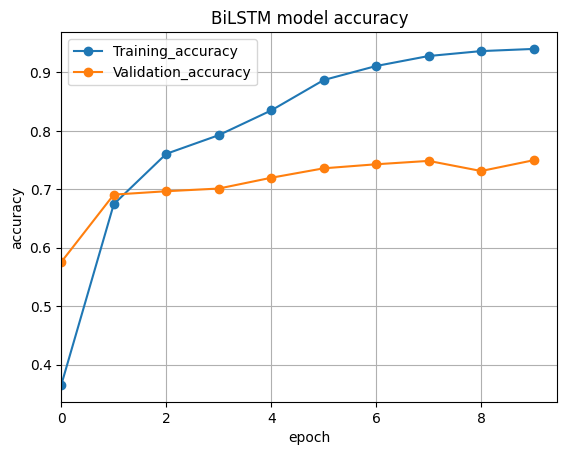

In [145]:
plt.plot(history_4.epoch, history_4.history['accuracy'], '-o', label='Training_accuracy')
plt.plot(history_4.epoch, history_4.history['val_accuracy'], '-o', label='Validation_accuracy')
plt.title('BiLSTM model accuracy')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('BiLSTM_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

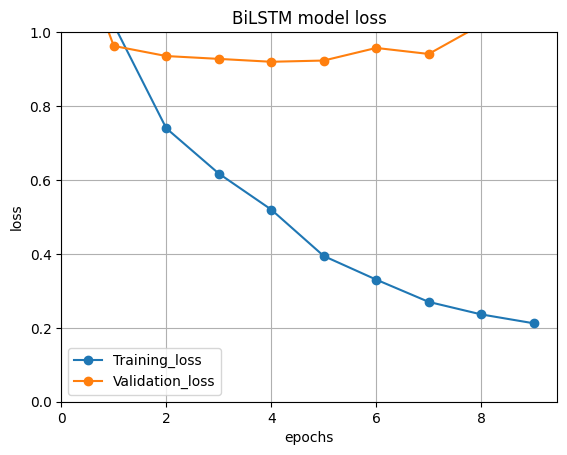

In [146]:
plt.plot(history_4.epoch, history_4.history['loss'], '-o', label='Training_loss')
plt.plot(history_4.epoch, history_4.history['val_loss'], '-o', label='Validation_loss')
plt.legend()
plt.title('BiLSTM model loss')
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.grid(True)
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
# plt.savefig('BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('BiLSTM_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [147]:
# plot_classification_report(report)
# plt.savefig('BiLSTM_plot_classif_report_'+ datetime.now().strftime("%Y%m%d_%H-%M%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.close()

AVG. Cross validation

In [148]:
df_results_cross_val.loc['BiLSTM avg cross validation data test 80%'] = [f1_avg_bilstm, precision_avg_bilstm, recall_avg_bilstm, accuracy_avg_bilstm, total_train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.733744,0.740093,0.733744,0.735149,248.351932
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.735687,0.737849,0.738920,0.738920,24.835193
CNN-BiLSTM avg cross validation data train 80%,0.735156,0.739658,0.735156,0.737624,285.316770
CNN-BiLSTM avg cross validation data test 20%,0.708535,0.715475,0.704986,0.704986,28.531677
1D_CNN avg cross validation data test 80%,0.743296,0.749615,0.743296,0.745545,473.186631
1D_CNN avg cross validation data test 20%,0.708742,0.731146,0.727839,0.727839,47.318663
BiLSTM avg cross validation data test 80%,0.762875,0.766756,0.762875,0.763861,561.154799


In [149]:
# Test cross validation 20%
model_bisltm_cross_validate = load_model(bisltm_cross_validate_model_path)
predicted = model_bisltm_cross_validate.predict(X_test_unseen)

predicted = np.argmax(predicted, axis=1)
# y_test = np.argmax(y_test_unseen,axis=1)

# report = classification_report(y_test_unseen, predicted, output_dict=True)
report = classification_report(y_test_unseen, predicted, digits=4)
# print(report)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_unseen, predicted)
print('Testing Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test_unseen, predicted,average='weighted')
print('Testing Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test_unseen, predicted,average='weighted')
print('Testing Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_unseen, predicted,average='weighted')
print('Testing F1 score: %f' % f1)

46/46 [==============================] - 1s 10ms/step
Testing Accuracy: 0.728532
Testing Precision: 0.727928
Testing Recall: 0.728532
Testing F1 score: 0.720912


In [150]:

df_results_cross_val.loc['BiLSTM avg cross validation data test 20%'] = [f1, precision, recall, accuracy, train_time]
df_results_cross_val

,F1_score,Precision,Recall,Accuracy,Training time
Att-Based CNN-BiLSTM avg cross validation data test 80%,0.733744,0.740093,0.733744,0.735149,248.351932
Att-Based CNN-BiLSTM avg cross validation data test 20%,0.735687,0.737849,0.738920,0.738920,24.835193
CNN-BiLSTM avg cross validation data train 80%,0.735156,0.739658,0.735156,0.737624,285.316770
CNN-BiLSTM avg cross validation data test 20%,0.708535,0.715475,0.704986,0.704986,28.531677
1D_CNN avg cross validation data test 80%,0.743296,0.749615,0.743296,0.745545,473.186631
1D_CNN avg cross validation data test 20%,0.708742,0.731146,0.727839,0.727839,47.318663
BiLSTM avg cross validation data test 80%,0.762875,0.766756,0.762875,0.763861,561.154799
BiLSTM avg cross validation data test 20%,0.720912,0.727928,0.728532,0.728532,56.115480


## save the results in csv

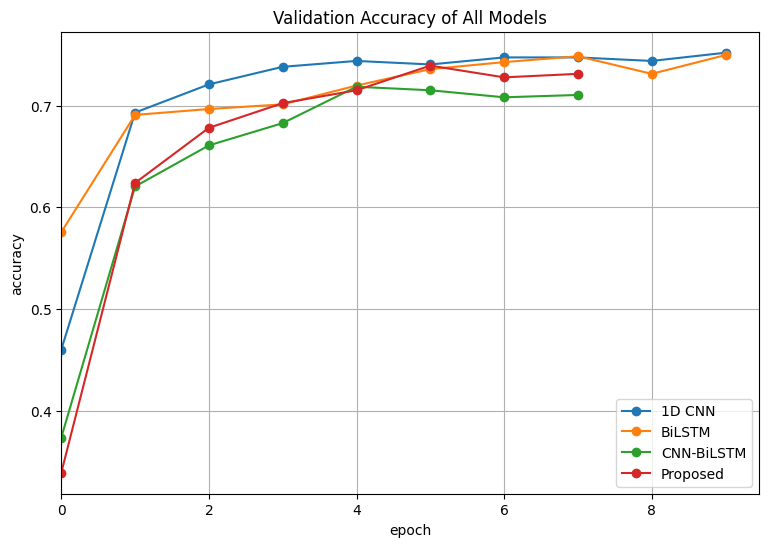

In [151]:
# plot overall accuracy on test set
fig = plt.figure(figsize=(9,6))
plt.plot(history_2.epoch, history_2.history['val_accuracy'], '-o', label='1D CNN')
# plt.plot(history_3.epoch, history_3.history['val_accuracy'], '-o', label='LSTM')
plt.plot(history_4.epoch, history_4.history['val_accuracy'], '-o', label='BiLSTM')
plt.plot(history_5.epoch, history_5.history['val_accuracy'], '-o', label='CNN-BiLSTM')
plt.plot(history_1.epoch, history_1.history['val_accuracy'], '-o', label='Proposed')
plt.title('Validation Accuracy of All Models')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('All_models_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('All_models_accuracy_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()

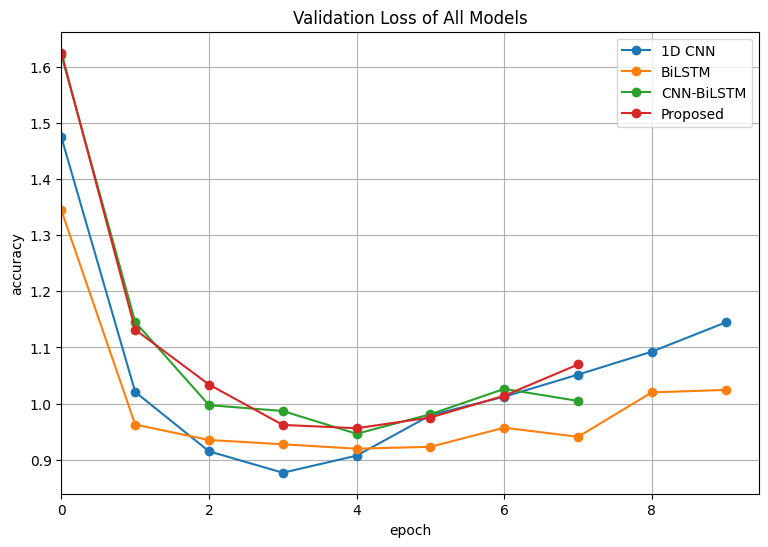

In [152]:
# plot overall looss on test set
fig = plt.figure(figsize=(9,6))
plt.plot(history_2.epoch, history_2.history['val_loss'], '-o', label='1D CNN')
# plt.plot(history_3.epoch, history_3.history['val_loss'], '-o', label='LSTM')
plt.plot(history_4.epoch, history_4.history['val_loss'], '-o', label='BiLSTM')
plt.plot(history_5.epoch, history_5.history['val_loss'], '-o', label='CNN-BiLSTM')
plt.plot(history_1.epoch, history_1.history['val_loss'], '-o', label='Proposed')
plt.title('Validation Loss of All Models')
plt.grid(True)
plt.legend()
plt.xlim(left=0)
plt.xlabel('epoch')
plt.ylabel('accuracy')
# plt.savefig('All_models_val_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.png', dpi=600, format='png', bbox_inches='tight')
# plt.savefig('All_models_val_loss_metrics_'+ datetime.now().strftime("%Y%m%d_%H-%M-%S") + '.pdf', dpi=600, format='pdf', bbox_inches='tight')
plt.show()
plt.close()